In [1]:
import os
import random
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split

from google.colab import drive, runtime

# Mount Google Drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Lung_Segmentation/scripts')
import lung_seg_utils

Mounted at /content/drive


In [2]:
# Define directories
drive_dir = '/content/drive/MyDrive'
project_dir = os.path.join(drive_dir, 'Covid-19_Presence')
models_dir = os.path.join(project_dir, 'models')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andyczhao/covidx-cxr2")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covidx-cxr2' dataset.
Path to dataset files: /kaggle/input/covidx-cxr2


In [4]:
for txt_path in ['train.txt','val.txt','test.txt']:
  txt_file = os.path.join(path, txt_path)
  all_data = pd.read_csv(txt_file, sep=' ', header=None, names=['patient_id','filename','label','source'])
  print(all_data['source'].value_counts())

source
bimcv         43142
stonybrook    12696
rsna           9719
sirm            878
ricord          834
cohen           471
actmed          101
fig1             22
Name: count, dtype: int64
source
rsna          3869
bimcv         3408
stonybrook     940
cohen           96
sirm            65
ricord          62
actmed          31
fig1             2
Name: count, dtype: int64
source
bimcv     8082
ricord     200
rsna       200
Name: count, dtype: int64


In [ ]:
import numpy as np
import cv2
import random
from typing import Tuple, Dict
import pandas as pd

class SourceMixingAugmentation:
    """
    Mix lung regions from one source with background from another source
    to break source-based shortcuts in medical imaging
    """

    def __init__(self, unet_model, all_data_df):
        self.unet_model = unet_model
        self.all_data_df = all_data_df

        # Group data by source for efficient sampling
        self.source_groups = {}
        for source in all_data_df['source'].unique():
            self.source_groups[source] = all_data_df[all_data_df['source'] == source]

    def generate_lung_mask(self, img_array):
        """Generate lung mask using U-Net model"""
        # Ensure correct input shape for U-Net (256x256x1)
        if img_array.shape != (256, 256):
            img_resized = cv2.resize(img_array, (256, 256))
        else:
            img_resized = img_array.copy()

        # Add batch and channel dimensions
        img_input = img_resized[np.newaxis, ..., np.newaxis]
        mask = self.unet_model.predict(img_input, verbose=0)
        mask_binary = (mask[0, ..., 0] > 0.5).astype(np.float32)

        return mask_binary

    def mix_sources(self,
                   primary_img_path: str,
                   primary_source: str,
                   target_img_size: Tuple[int, int] = (256, 256),
                   mix_probability: float = 0.5) -> np.ndarray:
        """
        Mix lung region from primary image with background from different source

        Args:
            primary_img_path: Path to the primary image (contains the lungs we want)
            primary_source: Source of the primary image
            target_img_size: Size to resize images to
            mix_probability: Probability of performing mixing (vs returning original)
        """

        # Load primary image
        primary_img = cv2.imread(primary_img_path, cv2.IMREAD_GRAYSCALE)
        if primary_img is None:
            raise ValueError(f"Could not load image: {primary_img_path}")

        primary_img = cv2.resize(primary_img, target_img_size)
        primary_img = primary_img.astype(np.float32) / 255.0

        # Decide whether to mix or return original
        if random.random() > mix_probability:
            return primary_img

        # Generate lung mask for primary image
        primary_mask = self.generate_lung_mask(primary_img)

        # Select a different source for background
        available_sources = [s for s in self.source_groups.keys() if s != primary_source]
        if not available_sources:
            return primary_img  # No other sources available

        background_source = random.choice(available_sources)
        background_samples = self.source_groups[background_source]

        # Randomly select a background image from different source
        background_row = background_samples.sample(1).iloc[0]
        background_img_path = background_row['filename']  # You'll need to construct full path

        # Load background image
        try:
            background_img = cv2.imread(background_img_path, cv2.IMREAD_GRAYSCALE)
            if background_img is None:
                return primary_img

            background_img = cv2.resize(background_img, target_img_size)
            background_img = background_img.astype(np.float32) / 255.0

            # Create mixed image: primary lungs + background everything else
            mixed_img = primary_img * primary_mask + background_img * (1 - primary_mask)

            return mixed_img

        except Exception as e:
            print(f"Error loading background image: {e}")
            return primary_img

    def advanced_mixing_strategies(self,
                                 primary_img_path: str,
                                 primary_source: str,
                                 strategy: str = 'random') -> np.ndarray:
        """
        Advanced mixing strategies to break different types of shortcuts
        """

        primary_img = cv2.imread(primary_img_path, cv2.IMREAD_GRAYSCALE)
        primary_img = cv2.resize(primary_img, (256, 256))
        primary_img = primary_img.astype(np.float32) / 255.0

        if strategy == 'contrast_transfer':
            # Transfer lung content but match background contrast/brightness
            return self._contrast_transfer_mixing(primary_img, primary_source)

        elif strategy == 'edge_mixing':
            # Mix based on edge patterns rather than lung masks
            return self._edge_based_mixing(primary_img, primary_source)

        elif strategy == 'frequency_mixing':
            # Mix high/low frequency components from different sources
            return self._frequency_domain_mixing(primary_img, primary_source)

        else:
            return self.mix_sources(primary_img_path, primary_source)

    def _contrast_transfer_mixing(self, primary_img, primary_source):
        """Mix lung regions but match background intensity distribution"""
        available_sources = [s for s in self.source_groups.keys() if s != primary_source]
        if not available_sources:
            return primary_img

        background_source = random.choice(available_sources)
        background_samples = self.source_groups[background_source]
        background_row = background_samples.sample(1).iloc[0]

        # Load background and match its intensity characteristics
        try:
            background_img_path = background_row['filename']
            background_img = cv2.imread(background_img_path, cv2.IMREAD_GRAYSCALE)
            background_img = cv2.resize(background_img, (256, 256))
            background_img = background_img.astype(np.float32) / 255.0

            # Generate masks
            primary_mask = self.generate_lung_mask(primary_img)

            # Match background intensity statistics
            bg_mean = background_img[primary_mask == 0].mean()
            bg_std = background_img[primary_mask == 0].std()

            primary_bg = primary_img[primary_mask == 0]
            primary_bg_normalized = (primary_bg - primary_bg.mean()) / primary_bg.std() * bg_std + bg_mean

            # Create mixed image with normalized background
            mixed_img = primary_img.copy()
            mixed_img[primary_mask == 0] = primary_bg_normalized

            return np.clip(mixed_img, 0, 1)

        except Exception:
            return primary_img

    def _edge_based_mixing(self, primary_img, primary_source):
        """Mix based on edge patterns to preserve lung boundaries but change textures"""
        # Detect edges in primary image
        edges = cv2.Canny((primary_img * 255).astype(np.uint8), 50, 150)
        edge_mask = (edges > 0).astype(np.float32)

        # Use edge mask instead of lung mask for mixing
        available_sources = [s for s in self.source_groups.keys() if s != primary_source]
        if not available_sources:
            return primary_img

        background_source = random.choice(available_sources)
        background_samples = self.source_groups[background_source]
        background_row = background_samples.sample(1).iloc[0]

        try:
            background_img_path = background_row['filename']
            background_img = cv2.imread(background_img_path, cv2.IMREAD_GRAYSCALE)
            background_img = cv2.resize(background_img, (256, 256))
            background_img = background_img.astype(np.float32) / 255.0

            # Mix: keep edges from primary, textures from background
            mixed_img = background_img * (1 - edge_mask) + primary_img * edge_mask

            return mixed_img

        except Exception:
            return primary_img

# Integration with your existing data generator
class SourceMixedDataGenerator(tf.keras.utils.Sequence):
    """
    Modified generator that applies source mixing augmentation
    """

    def __init__(self, original_generator, mixing_augmenter, mixing_probability=0.3):
        self.original_gen = original_generator
        self.mixer = mixing_augmenter
        self.mixing_prob = mixing_probability

    def __len__(self):
        return len(self.original_gen)

    def __getitem__(self, idx):
        # Get original batch
        (cropped_imgs, masked_imgs), labels = self.original_gen[idx]

        # Apply source mixing to some samples in the batch
        mixed_cropped = []
        mixed_masked = []

        for i in range(len(cropped_imgs)):
            if random.random() < self.mixing_prob:
                # Get source info for this sample
                sample_idx = self.original_gen.indices[idx * self.original_gen.batch_size + i]
                sample_row = self.original_gen.df.iloc[sample_idx]
                img_path = sample_row['filename']
                img_source = sample_row['source']

                # Apply source mixing
                try:
                    mixed_img = self.mixer.mix_sources(img_path, img_source)

                    # Convert back to your pipeline format
                    mixed_cropped_processed = self.process_for_model(mixed_img, 'cropped')
                    mixed_masked_processed = self.process_for_model(mixed_img, 'masked')

                    mixed_cropped.append(mixed_cropped_processed)
                    mixed_masked.append(mixed_masked_processed)

                except Exception as e:
                    # Fallback to original if mixing fails
                    mixed_cropped.append(cropped_imgs[i])
                    mixed_masked.append(masked_imgs[i])
            else:
                # Keep original
                mixed_cropped.append(cropped_imgs[i])
                mixed_masked.append(masked_imgs[i])

        return (np.array(mixed_cropped), np.array(mixed_masked)), labels

    def process_for_model(self, img_array, processing_type):
        """Convert mixed image back to model input format"""
        # This would need to replicate your existing preprocessing pipeline
        # including cropping, masking, RGB conversion, and Xception preprocessing
        pass


mixer = SourceMixingAugmentation(unet_model, df_train)

# Create mixed data generator
mixed_train_gen = SourceMixedDataGenerator(
    original_generator=train_gen,
    mixing_augmenter=mixer,
    mixing_probability=0.4  # 40% of samples get source mixing
)


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
import joblib

class COVIDxDualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, txt_file, img_dir, unet_model, project_dir, batch_size=32, img_size=(256,256), shuffle=True, augment=False, is_train=False):
        self.all_data = pd.read_csv(txt_file, sep=' ', header=None, names=['patient_id','filename','label','source'])
        self.all_filenames=[]
        self.is_train = is_train
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.unet_model = unet_model
        self.project_dir = project_dir

        # Load or create label encoder
        label_encoder_path = os.path.join(project_dir, 'label_encoder.joblib')
        if os.path.exists(label_encoder_path):
            self.label_encoder = joblib.load(label_encoder_path)
        else:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.all_data['label'])
            joblib.dump(self.label_encoder, label_encoder_path)

        self.all_data['label_encoded'] = self.label_encoder.transform(self.all_data['label'])
        self.df = self.all_data.copy()

        self.on_epoch_end()

        if self.augment:
            # Conservative augmentations for medical imaging
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=4,            # Small rotations ±2 degrees
                zoom_range=0.05,             # Small zoom in/out
                horizontal_flip=True,        # Keep - lungs are symmetric
                width_shift_range=0.05,      # Shift up to ±2% horizontally
                height_shift_range=0.05,
                                              # Shift up to ±2% vertically
                fill_mode='constant',        # Fill mode for pixels outside boundaries
                cval=0.0                     # Fill value if fill_mode='constant'
            )
        else:
            self.datagen = None

    def __len__(self):
      return int(np.ceil(len(self.df) / self.batch_size))

    def crop_to_mask_with_padding(self, img, mask, padding=10):
      """
      Crop image around mask with padding.

      Args:
        img (np.ndarray): Original single channel image of shape (H, W).
        mask (np.ndarray): Binary mask of shape (H, W).
        padding (int): Number of pixels to pad on all sides.

      Returns:
        np.ndarray: Cropped image patch.
      """
      # Find where the mask is positive
      coords = np.argwhere(mask > 0)
      if coords.size == 0:
          # Empty mask, return resized full image as fallback
          return cv2.resize(img, (self.img_size[1], self.img_size[0]))

      # Bounding box of mask
      y0, x0 = coords.min(axis=0)
      y1, x1 = coords.max(axis=0)

      # Add padding and clamp to image boundaries
      y0 = max(y0 - padding, 0)
      x0 = max(x0 - padding, 0)
      y1 = min(y1 + padding, img.shape[0])
      x1 = min(x1 + padding, img.shape[1])

      # Crop the image
      cropped_img = img[y0:y1, x0:x1]

      return cropped_img

    def apply_mask_to_full_image(self, img, mask):
        """
        Apply mask to full image, zeroing out non-lung regions.

        Args:
            img (np.ndarray): Original single channel image of shape (H, W).
            mask (np.ndarray): Binary mask of shape (H, W).

        Returns:
            np.ndarray: Masked image with only lung regions visible.
        """
        # Element-wise multiplication to zero out non-lung regions
        masked_img = img * mask
        return masked_img

    def __getitem__(self, index):
      batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
      imgs = []
      labels = []

      # Load images WITHOUT augmentation first
      for i in batch_indices:
          row = self.df.iloc[i]
          img_path = os.path.join(self.img_dir, row['filename'])

          # Check if file exists
          if not os.path.exists(img_path):
              print(f"Warning: File not found: {img_path}")
              continue

          # Load grayscale image as numpy array for cropping
          img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size, color_mode='grayscale')
          img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0  # Shape (H,W)

          imgs.append(img_arr)
          labels.append(row['label_encoded'])
          self.all_filenames.append(row['filename'])

      if len(imgs) == 0:
          # Return empty batch if no valid images found
          return [np.array([]), np.array([])], np.array([])

      imgs_np = np.array(imgs, dtype=np.float32)

      imgs_tf = tf.convert_to_tensor(imgs_np[..., np.newaxis], dtype=tf.float32)  # Add channel axis for U-Net input

      # Generate mask predictions using U-Net on clean images
      pred_masks = self.unet_model.predict(imgs_tf, verbose=0)
      pred_masks = (pred_masks > 0.5).astype(np.float32)

      cropped_imgs = []
      masked_imgs = []

      for i in range(len(imgs_np)):
          # Input 1: Cropped image with padding (anatomical context)
          cropped_img = self.crop_to_mask_with_padding(imgs_np[i], pred_masks[i].squeeze(), padding=10)
          resized_cropped = self.resize_and_convert_to_rgb(cropped_img, target_size=(299, 299, 3))
          cropped_imgs.append(resized_cropped)

          # Input 2: Masked image (pure lung parenchyma)
          masked_img = self.apply_mask_to_full_image(imgs_np[i], pred_masks[i].squeeze())
          resized_masked = self.resize_and_convert_to_rgb(masked_img, target_size=(299, 299, 3))
          masked_imgs.append(resized_masked)

      cropped_imgs = np.array(cropped_imgs, dtype=np.float32)
      masked_imgs = np.array(masked_imgs, dtype=np.float32)

      # Apply augmentation if enabled (same augmentation to both inputs)
      if self.augment and self.datagen is not None:
          augmented_cropped = []
          augmented_masked = []

          for i in range(len(cropped_imgs)):
              # Use same random seed for both inputs to ensure consistent augmentation
              seed = np.random.randint(0, 2147483647)

              # Augment cropped image
              np.random.seed(seed)
              aug_cropped = self.datagen.random_transform(cropped_imgs[i])
              augmented_cropped.append(aug_cropped)

              # Augment masked image with same transformation
              np.random.seed(seed)
              aug_masked = self.datagen.random_transform(masked_imgs[i])
              augmented_masked.append(aug_masked)

          cropped_imgs = np.array(augmented_cropped, dtype=np.float32)
          masked_imgs = np.array(augmented_masked, dtype=np.float32)

      # Preprocess both inputs for Xception: scale pixels to [-1, 1]
      cropped_imgs_255 = cropped_imgs * 255.0
      masked_imgs_255 = masked_imgs * 255.0
      final_cropped_imgs = preprocess_input(cropped_imgs_255)
      final_masked_imgs = preprocess_input(masked_imgs_255)


      # Convert labels to categorical
      labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_encoder.classes_))


      # Return as list of two inputs for dual-branch model
      return (final_cropped_imgs, final_masked_imgs), labels


    def resize_and_convert_to_rgb(self, img_array, target_size=(299, 299, 3)):
        """
        Resizes a single-channel image array and converts it to a 3-channel RGB image.

        Args:
            img_array (np.ndarray): The input image as a NumPy array.
            target_size (tuple): The desired output size (height, width, channels).

        Returns:
            np.ndarray: The resized and 3-channel image array.
        """
        # Squeeze to remove single dimensions if present
        if len(img_array.shape) == 3 and img_array.shape[-1] == 1:
            img_array = np.squeeze(img_array, axis=-1)

        # Resize the image
        resized_img = cv2.resize(img_array, (target_size[1], target_size[0]))

        # Convert single channel to 3 channels by stacking
        if len(resized_img.shape) == 2:
            resized_img = np.stack([resized_img] * 3, axis=-1)

        return resized_img

    def on_epoch_end(self):
        if self.is_train:
            # Balance classes by undersampling majority class
            positives = self.all_data[self.all_data['label'] == 'positive']
            negatives = self.all_data[self.all_data['label'] == 'negative']

            # Determine which class has fewer samples
            min_samples = min(len(positives), len(negatives))

            # Sample equal numbers from each class
            pos_sample = positives.sample(min_samples) if len(positives) > min_samples else positives
            neg_sample = negatives.sample(min_samples) if len(negatives) > min_samples else negatives

            self.df = pd.concat([neg_sample, pos_sample])
            self.df = self.df.sample(frac=0.4).reset_index(drop=True)
        else:
            self.df = self.all_data.copy()

        self.indices = list(range(len(self.df)))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def get_class_distribution(self):
        """Return the distribution of classes in current dataset"""
        return self.df['label'].value_counts()

# Example usage function
def create_dual_input_generators(path, models_dir, project_dir, batch_sizes=None):
    """
    Create train, validation, and test generators for dual-input model

    Args:
        path: Base path containing train.txt, val.txt, test.txt and corresponding image folders
        models_dir: Directory containing the U-Net model
        project_dir: Directory for saving/loading label encoder
        batch_sizes: Dict with 'train', 'val', 'test' batch sizes

    Returns:
        tuple: (train_gen, val_gen, test_gen)
    """
    if batch_sizes is None:
        batch_sizes = {'train': 32, 'val': 16, 'test': 8}

    # Model loading
    model_path = os.path.join(models_dir, 'generator_gan_model_run2.keras')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"U-Net model not found at: {model_path}")

    generator_unet = tf.keras.models.load_model(model_path)

    # File paths
    train_txt = os.path.join(path, "train.txt")
    train_img_dir = os.path.join(path, "train")
    val_txt = os.path.join(path, "val.txt")
    val_img_dir = os.path.join(path, "val")
    test_txt = os.path.join(path, "test.txt")
    test_img_dir = os.path.join(path, "test")

    # Create generators
    train_gen = COVIDxDualInputGenerator(
        txt_file=train_txt,
        img_dir=train_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['train'],
        img_size=(256, 256),
        shuffle=True,
        augment=True,
        is_train=True
    )

    val_gen = COVIDxDualInputGenerator(
        txt_file=val_txt,
        img_dir=val_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['val'],
        img_size=(256, 256),
        shuffle=False,  # Usually don't shuffle validation
        augment=False,
        is_train=False
    )

    test_gen = COVIDxDualInputGenerator(
        txt_file=test_txt,
        img_dir=test_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['test'],
        img_size=(256, 256),
        shuffle=False,  # Don't shuffle test data
        augment=False,
        is_train=False
    )

    return train_gen, val_gen, test_gen
train_gen,val_gen,test_gen=create_dual_input_generators(path, models_dir, project_dir, batch_sizes=None)

In [ ]:
#claude
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
import joblib

class COVIDxMaskedImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, txt_file, img_dir, unet_model, project_dir, batch_size=32, img_size=(256,256), shuffle=True, augment=False, is_train=False):
        self.all_data = pd.read_csv(txt_file, sep=' ', header=None, names=['patient_id','filename','label','source'])
        self.all_filenames=[]
        self.is_train = is_train
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.unet_model = unet_model
        self.project_dir = project_dir

        # Load or create label encoder
        label_encoder_path = os.path.join(project_dir, 'label_encoder.joblib')
        if os.path.exists(label_encoder_path):
            self.label_encoder = joblib.load(label_encoder_path)
        else:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.all_data['label'])
            joblib.dump(self.label_encoder, label_encoder_path)

        self.all_data['label_encoded'] = self.label_encoder.transform(self.all_data['label'])
        self.df = self.all_data.copy()

        self.on_epoch_end()

        if self.augment:
            # Conservative augmentations for medical imaging
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=4,            # Small rotations ±2 degrees
                zoom_range=0.05,             # Small zoom in/out
                horizontal_flip=True,        # Keep - lungs are symmetric
                width_shift_range=0.05,      # Shift up to ±2% horizontally
                height_shift_range=0.05,     # Shift up to ±2% vertically
                fill_mode='constant',        # Fill mode for pixels outside boundaries
                cval=0.0                     # Fill value if fill_mode='constant'
            )
        else:
            self.datagen = None

    def __len__(self):
      return int(np.ceil(len(self.df) / self.batch_size))

    def crop_to_mask_with_padding(self, img, mask, padding=10):
      """
      Crop image around mask with padding.

      Args:
        img (np.ndarray): Original single channel image of shape (H, W).
        mask (np.ndarray): Binary mask of shape (H, W).
        padding (int): Number of pixels to pad on all sides.

      Returns:
        np.ndarray: Cropped image patch.
      """
      # Find where the mask is positive
      coords = np.argwhere(mask > 0)
      if coords.size == 0:
          # Empty mask, return resized full image as fallback
          return cv2.resize(img, (self.img_size[1], self.img_size[0]))

      # Bounding box of mask
      y0, x0 = coords.min(axis=0)
      y1, x1 = coords.max(axis=0)

      # Add padding and clamp to image boundaries
      y0 = max(y0 - padding, 0)
      x0 = max(x0 - padding, 0)
      y1 = min(y1 + padding, img.shape[0])
      x1 = min(x1 + padding, img.shape[1])

      # Crop the image
      cropped_img = img[y0:y1, x0:x1]

      return cropped_img


    def __getitem__(self, index):
      batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
      imgs = []
      labels = []

      # Load images WITHOUT augmentation first
      for i in batch_indices:
          row = self.df.iloc[i]
          img_path = os.path.join(self.img_dir, row['filename'])

          # Check if file exists
          if not os.path.exists(img_path):
              print(f"Warning: File not found: {img_path}")
              continue

          # Load grayscale image as numpy array for cropping
          img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size, color_mode='grayscale')
          img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0  # Shape (H,W)

          imgs.append(img_arr)
          labels.append(row['label_encoded'])
          self.all_filenames.append(row['filename'])

      if len(imgs) == 0:
          # Return empty batch if no valid images found
          return np.array([]), np.array([])

      imgs_np = np.array(imgs, dtype=np.float32)

      imgs_tf = tf.convert_to_tensor(imgs_np[..., np.newaxis], dtype=tf.float32)  # Add channel axis for U-Net input

      # Generate mask predictions using U-Net on clean images
      pred_masks = self.unet_model.predict(imgs_tf, verbose=0)
      pred_masks = (pred_masks > 0.5).astype(np.float32)

      masked_cropped_imgs = []
      for i in range(len(imgs_np)):
          # Crop original grayscale image to mask with padding
          cropped_img = self.crop_to_mask_with_padding(imgs_np[i], pred_masks[i].squeeze(), padding=10)

          # Resize and convert to 3-channel RGB for Xception
          resized_img = self.resize_and_convert_to_rgb(cropped_img, target_size=(299, 299, 3))

          masked_cropped_imgs.append(resized_img)

      masked_cropped_imgs = np.array(masked_cropped_imgs, dtype=np.float32)

      # Apply augmentation if enabled
      if self.augment and self.datagen is not None:
          augmented_imgs = []
          for img in masked_cropped_imgs:
              augmented_img = self.datagen.random_transform(img)
              augmented_imgs.append(augmented_img)
          masked_cropped_imgs = np.array(augmented_imgs, dtype=np.float32)

      # Preprocess for Xception: scale pixels to [-1, 1]
      final_imgs = preprocess_input(masked_cropped_imgs)

      # Convert labels to categorical
      labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_encoder.classes_))

      return final_imgs, labels


    def resize_and_convert_to_rgb(self, img_array, target_size=(299, 299, 3)):
        """
        Resizes a single-channel image array and converts it to a 3-channel RGB image.

        Args:
            img_array (np.ndarray): The input image as a NumPy array.
            target_size (tuple): The desired output size (height, width, channels).

        Returns:
            np.ndarray: The resized and 3-channel image array.
        """
        # Squeeze to remove single dimensions if present
        if len(img_array.shape) == 3 and img_array.shape[-1] == 1:
            img_array = np.squeeze(img_array, axis=-1)

        # Resize the image
        resized_img = cv2.resize(img_array, (target_size[1], target_size[0]))

        # Convert single channel to 3 channels by stacking
        if len(resized_img.shape) == 2:
            resized_img = np.stack([resized_img] * 3, axis=-1)

        return resized_img

    def on_epoch_end(self):
        if self.is_train:
            # Balance classes by undersampling majority class
            positives = self.all_data[self.all_data['label'] == 'positive']
            negatives = self.all_data[self.all_data['label'] == 'negative']

            # Determine which class has fewer samples
            min_samples = min(len(positives), len(negatives))

            # Sample equal numbers from each class
            pos_sample = positives.sample(min_samples) if len(positives) > min_samples else positives
            neg_sample = negatives.sample(min_samples) if len(negatives) > min_samples else negatives

            self.df = pd.concat([neg_sample, pos_sample])
            self.df = self.df.sample(frac=0.4).reset_index(drop=True)
        else:
            self.df = self.all_data.copy()

        self.indices = list(range(len(self.df)))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def get_class_distribution(self):
        """Return the distribution of classes in current dataset"""
        return self.df['label'].value_counts()

# Example usage function
def create_generators(path, models_dir, project_dir, batch_sizes=None):
    """
    Create train, validation, and test generators

    Args:
        path: Base path containing train.txt, val.txt, test.txt and corresponding image folders
        models_dir: Directory containing the U-Net model
        project_dir: Directory for saving/loading label encoder
        batch_sizes: Dict with 'train', 'val', 'test' batch sizes

    Returns:
        tuple: (train_gen, val_gen, test_gen)
    """
    if batch_sizes is None:
        batch_sizes = {'train': 32, 'val': 16, 'test': 8}

    # Model loading
    model_path = os.path.join(models_dir, 'generator_gan_model_run2.keras')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"U-Net model not found at: {model_path}")

    generator_unet = tf.keras.models.load_model(model_path)

    # File paths
    train_txt = os.path.join(path, "train.txt")
    train_img_dir = os.path.join(path, "train")
    val_txt = os.path.join(path, "val.txt")
    val_img_dir = os.path.join(path, "val")
    test_txt = os.path.join(path, "test.txt")
    test_img_dir = os.path.join(path, "test")

    # Create generators
    train_gen = COVIDxMaskedImageGenerator(
        txt_file=train_txt,
        img_dir=train_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['train'],
        img_size=(256, 256),
        shuffle=True,
        augment=True,
        is_train=True
    )

    val_gen = COVIDxMaskedImageGenerator(
        txt_file=val_txt,
        img_dir=val_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['val'],
        img_size=(256, 256),
        shuffle=False,  # Usually don't shuffle validation
        augment=False,
        is_train=False
    )

    test_gen = COVIDxMaskedImageGenerator(
        txt_file=test_txt,
        img_dir=test_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['test'],
        img_size=(256, 256),
        shuffle=False,  # Don't shuffle test data
        augment=False,
        is_train=False
    )

    return train_gen, val_gen, test_gen

In [ ]:
# Example usage
train_gen, val_gen, test_gen = create_generators(
    path=path,
    models_dir=models_dir,
    project_dir=project_dir
)

# Check class distribution
print("Train distribution:", train_gen.get_class_distribution())
print("Val distribution:", val_gen.get_class_distribution())

Train distribution: label
negative    4294
positive    4237
Name: count, dtype: int64
Val distribution: label
positive    4241
negative    4232
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Example: get unique labels (strings or categories)
labels = train_gen.df['label'].unique()

# Create and fit LabelEncoder on unique labels
shared_label_encoder = LabelEncoder()
shared_label_encoder.fit(labels)

# Save the fitted encoder to disk
filename = os.path.join(project_dir, 'label_encoder.joblib')
joblib.dump(shared_label_encoder, filename)

print(f"LabelEncoder saved to {filename}")



LabelEncoder saved to /content/drive/MyDrive/Covid-19_Presence/label_encoder.joblib


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np

def rgb_to_grayscale_and_resize(img_rgb):
    """
    Convert an RGB image of shape (299, 299, 3) to grayscale and resize to (256, 256, 1).

    Args:
        img_rgb: numpy array of shape (299, 299, 3), dtype float32 or uint8

    Returns:
        img_gray_resized: numpy array of shape (256, 256, 1), dtype float32
    """
    # Convert RGB to grayscale using weighted sum
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)  # shape (299,299)

    # Resize grayscale image to (256, 256)
    img_resized = cv2.resize(img_gray, (256, 256), interpolation=cv2.INTER_LINEAR)

    # Add channel dimension to get (256, 256, 1)
    img_gray_resized = img_resized[:, :, np.newaxis]

    # Convert to float32 in case it's not
    img_gray_resized = img_gray_resized.astype(np.float32)

    return img_gray_resized
# Just get one batch
masked_images, labels = train_gen[0]

print("Batch masked_images shape:", masked_images.shape)  # Should be (batch_size, 299, 299, 3)
print("Batch labels shape:", labels.shape)

# Print individual shapes if needed
for i in range(min(10, masked_images.shape[0])):
    print(f"Image {i} shape:", masked_images[i].shape)  # Should be (299, 299, 3)
    print(f"Label {i} shape:", labels[i])  # Should be (2,)











Batch masked_images shape: (32, 299, 299, 3)
Batch labels shape: (32, 2)
Image 0 shape: (299, 299, 3)
Label 0 shape: [0. 1.]
Image 1 shape: (299, 299, 3)
Label 1 shape: [0. 1.]
Image 2 shape: (299, 299, 3)
Label 2 shape: [0. 1.]
Image 3 shape: (299, 299, 3)
Label 3 shape: [1. 0.]
Image 4 shape: (299, 299, 3)
Label 4 shape: [0. 1.]
Image 5 shape: (299, 299, 3)
Label 5 shape: [0. 1.]
Image 6 shape: (299, 299, 3)
Label 6 shape: [1. 0.]
Image 7 shape: (299, 299, 3)
Label 7 shape: [0. 1.]
Image 8 shape: (299, 299, 3)
Label 8 shape: [0. 1.]
Image 9 shape: (299, 299, 3)
Label 9 shape: [1. 0.]


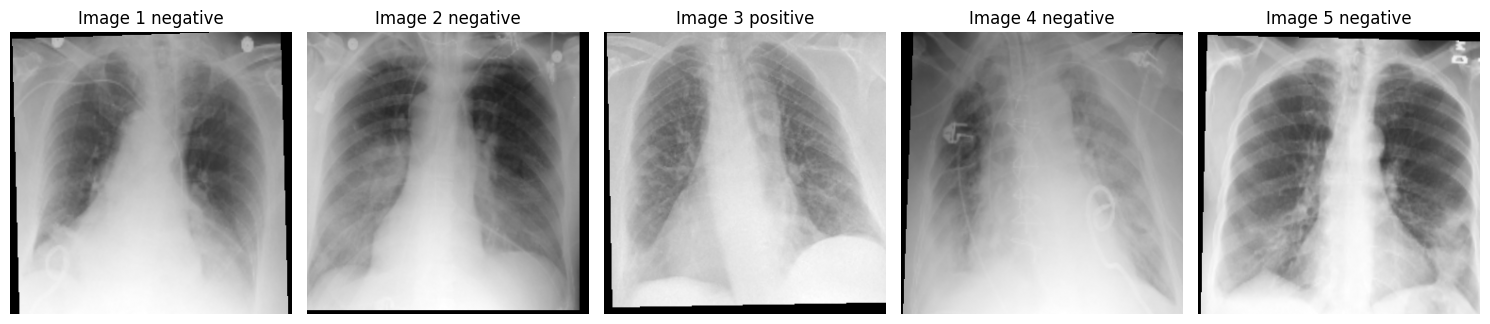

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have the first batch from your data generator
masked_images, labels= train_gen[2]

# Take the first 5 images from the batch
first_five_images = masked_images[:5]
first_five_labels=labels[:5]
# first_five_labels is shape (batch_size, num_classes), e.g., one-hot vectors

# Convert one-hot vectors to class indices (integers)
label_indices = np.argmax(first_five_labels, axis=1)

# Now inverse transform using integer indices
decoded_labels = train_gen.label_encoder.inverse_transform(label_indices)


plt.figure(figsize=(15, 6))
for i, img in enumerate(first_five_images):
    # img is a NumPy array; no need for .numpy()
    grayscale_img = img.mean(axis=-1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title(f'Image {i+1} {decoded_labels[i]}')
    plt.axis('off')


plt.tight_layout()
plt.show()

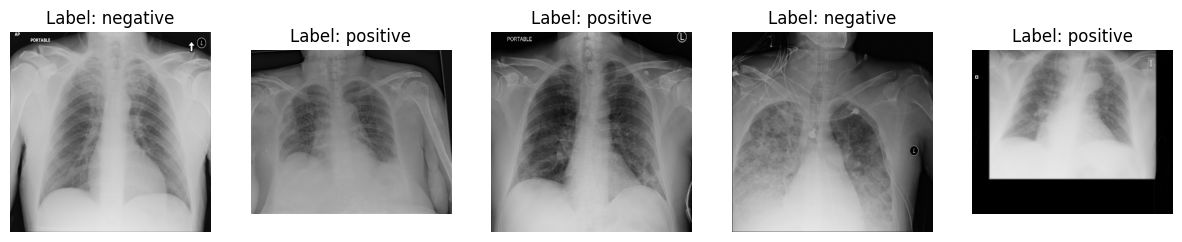

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

df = train_gen.df
img_dir = train_gen.img_dir

indices = train_gen.indices[:5]

plt.figure(figsize=(15, 6))
for plot_idx, i in enumerate(indices, start=1):
    img_path = os.path.join(img_dir, df.iloc[i]['filename'])
    img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale')
    plt.subplot(1, 5, plot_idx)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {df.iloc[i]['label']}")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2

def build_xception_classifier(num_classes, trainable=False):
    """
    Build Xception classifier with option to freeze/unfreeze base model

    Args:
        num_classes: Number of output classes
        trainable: Whether to make base model trainable initially
    """
    # Input image size expected by Xception model (3 channels)
    IMAGE_SIZE = (299, 299, 3)

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE
    )

    # Start with base model frozen for initial training
    base_model.trainable = trainable

    inputs = layers.Input(shape=IMAGE_SIZE)
    x = base_model(inputs, training=False)  # Set training=False when frozen

    # Add custom classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)  # Add batch normalization
    x = layers.Dense(512, activation='relu')(x)  # Slightly larger dense layer
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Lower dropout for second layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model, base_model

def unfreeze_base_model(model, base_model, fine_tune_at=100):
    """
    Unfreeze the base model for fine-tuning

    Args:
        model: The full model
        base_model: The base Xception model
        fine_tune_at: Layer index from which to start fine-tuning (default: 100)
    """
    base_model.trainable = True

    # Fine-tune from this layer onwards
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"Unfrozen layers: {len([l for l in base_model.layers if l.trainable])}")
    return model

# Build model with frozen base initially
num_classes = 2  # COVID positive vs negative
model, base_model = build_xception_classifier(num_classes, trainable=False)

# Phase 1: Train with frozen base model
print("=== PHASE 1: Training with frozen base model ===")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Higher LR for frozen base
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()







# Alternative: Single-phase training with partial unfreezing
def build_partially_frozen_xception(num_classes, fine_tune_from=100):
    """
    Alternative approach: Build model with only top layers unfrozen
    """
    IMAGE_SIZE = (299, 299, 3)

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE
    )

    # Freeze early layers, unfreeze later layers
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_from]:
        layer.trainable = False

    inputs = layers.Input(shape=IMAGE_SIZE)
    x = base_model(inputs)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
=== PHASE 1: Training with frozen base model ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,050,602 (84.12 MB)

 Trainable params: 1,185,026 (4.52 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import runtime


# Phase 1 Training Parameters
epochs = 3  # Increased from 5 - you might need more for head to converge
initial_lr = 1e-4

print("=== PHASE 1: Training with frozen base model ===")
print(f"Initial learning rate: {initial_lr}")
print(f"Epochs: {epochs}")
print(f"Training samples per epoch: {len(train_gen) * train_gen.batch_size}")
print(f"Validation samples: {len(val_gen) * val_gen.batch_size}")


best_model_path = os.path.join(models_dir, 'best_covid_phase1.keras')
final_model_path = os.path.join(models_dir, 'final_covid_phase1.keras')
try:
  model.load_weights(best_model_path)
  print(f"Loaded best model weights from: {best_model_path}")
except:
  print("No best model found")
# Create comprehensive callbacks
callbacks = [
    # Save best model based on validation loss
    ModelCheckpoint(
        filepath=best_model_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1,
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=3,  # Stop if no improvement for 3 epochs
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half
        patience=2,  # Wait 2 epochs before reducing
        min_lr=1e-7,  # Don't go below this LR
        verbose=1
    )
]

# Compile model for Phase 1
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model info
print(f"\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
trainable_count = sum([tf.reduce_prod(var.shape) for var in model.trainable_variables])
print(f"Trainable parameters: {trainable_count:,}")
non_trainable_count = model.count_params() - trainable_count
print(f"Non-trainable parameters: {non_trainable_count:,}")

# Check class distribution
print(f"\nClass distribution:")
print(f"Training: {train_gen.get_class_distribution()}")
print(f"Validation: {val_gen.get_class_distribution()}")

# Start training
print(f"\n{'='*50}")
print("Starting Phase 1 Training...")
print(f"{'='*50}")
print('models dir: ', models_dir)
try:
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    # Save final model (regardless of whether it's the best)
    model.save(final_model_path)
    print(f"Final model saved to: {final_model_path}")

    # Print training results
    print(f"\n{'='*50}")
    print("Phase 1 Training Complete!")
    print(f"{'='*50}")

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss) + 1
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")

except KeyboardInterrupt:
    print("\nTraining interrupted by user")
    model.save(os.path.join(models_dir, 'interrupted_model_phase1.keras'))

except Exception as e:
    print(f"\nTraining failed with error: {str(e)}")
    model.save(os.path.join(models_dir, 'error_model_phase1.keras'))
    raise

# Plot training history
def plot_training_history(history, phase="Phase 1"):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'{phase} Training History')

    # Accuracy
    axes[0,0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0,0].set_title('Model Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Loss
    axes[0,1].plot(history.history['loss'], label='Training Loss')
    axes[0,1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0,1].set_title('Model Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Precision
    if 'precision' in history.history:
        axes[1,0].plot(history.history['precision'], label='Training Precision')
        axes[1,0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1,0].set_title('Model Precision')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].legend()
        axes[1,0].grid(True)

    # Recall
    if 'recall' in history.history:
        axes[1,1].plot(history.history['recall'], label='Training Recall')
        axes[1,1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1,1].set_title('Model Recall')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Recall')
        axes[1,1].legend()
        axes[1,1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, f'{phase.lower().replace(" ", "_")}_history.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

# Plot the results
if 'history' in locals():
    plot_training_history(history, "Phase 1")

print(f"\nReady for Phase 2! Load the best model from: {best_model_path}")
print("Next steps:")
print("1. Load the best Phase 1 model")
print("2. Unfreeze base model layers")
print("3. Recompile with lower learning rate")
print("4. Train for more epochs")
#runtime.unassign()

=== PHASE 1: Training with frozen base model ===
Initial learning rate: 0.0001
Epochs: 3
Training samples per epoch: 8512
Validation samples: 8464
Loaded best model weights from: /content/drive/MyDrive/Covid-19_Presence/models/best_covid_phase1.keras

Model Summary:
Total parameters: 22,050,602
Trainable parameters: 1,185,026
Non-trainable parameters: 20,865,576

Class distribution:
Training: label
positive    4275
negative    4256
Name: count, dtype: int64
Validation: label
positive    4241
negative    4232
Name: count, dtype: int64

Starting Phase 1 Training...
models dir:  /content/drive/MyDrive/Covid-19_Presence/models
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6666 - loss: 0.5928 - precision: 0.6666 - recall: 0.6666
Epoch 1: val_loss improved from inf to 0.52092, saving model to /content/drive/MyDrive/Covid-19_Presence/models/best_covid_phase1.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 729s 3s/step - accuracy: 0.6667 - loss: 0.5927 - precision: 0.6667 - recall: 0.6667

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


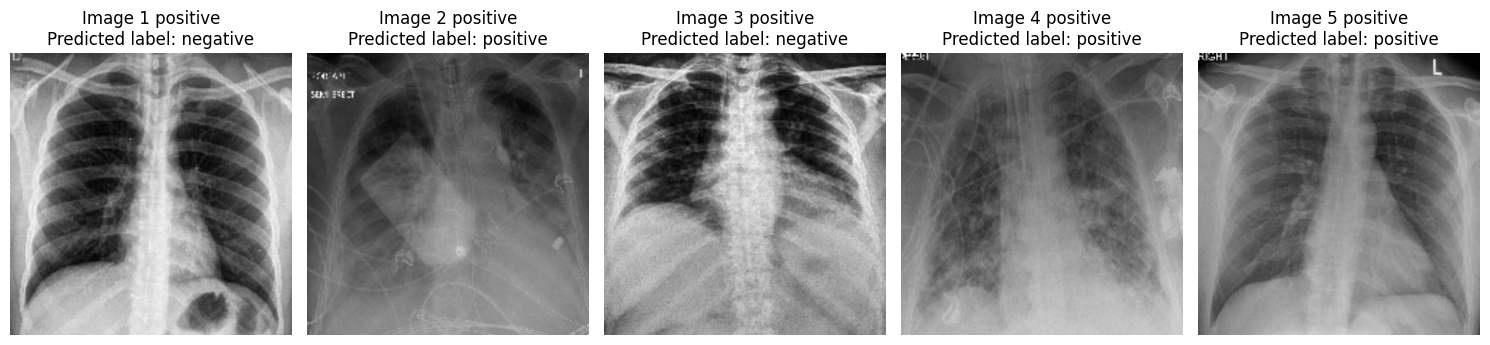

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have the first batch from your data generator
masked_images, labels = test_gen[1]

# Take the first 5 images from the batch
first_five_images = masked_images[:5]
first_five_labels=labels[:5]
preds=model.predict(first_five_images)
preds=np.argmax(preds, axis=1)
preds=[test_gen.label_encoder.classes_[p] for p in preds]
# first_five_labels is shape (batch_size, num_classes), e.g., one-hot vectors

# Convert one-hot vectors to class indices (integers)
label_indices = np.argmax(first_five_labels, axis=1)

# Now inverse transform using integer indices
decoded_labels = train_gen.label_encoder.inverse_transform(label_indices)


plt.figure(figsize=(15, 6))
for i, img in enumerate(first_five_images):
    # img is a NumPy array; no need for .numpy()
    grayscale_img = img.mean(axis=-1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title(f'Image {i+1} {decoded_labels[i]}\nPredicted label: {preds[i]}')
    plt.axis('off')


plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


only_unfreeze_some=True
# Phase 2: Build model with trainable=True
print("=== PHASE 2: Fine-tuning ===")
model, base_model = build_xception_classifier(num_classes=2, trainable=True)

# Load Phase 1 weights
phase1_weights = os.path.join(models_dir, 'best_covid_phase1.keras')
phase2_weights=os.path.join(models_dir, 'best_covid_phase2.keras')
model.load_weights(phase1_weights)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in base_model.layers[:-5]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

# Compile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Simple callbacks
callbacks = [
    ModelCheckpoint(os.path.join(models_dir, 'best_covid_phase2.keras'),
                   save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Train Phase 2
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("Phase 2 complete!")

=== PHASE 2: Fine-tuning ===
Trainable params: 4,351,746
Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 753s 3s/step - accuracy: 0.6075 - loss: 0.7260 - val_accuracy: 0.5011 - val_loss: 27.9096
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 727s 3s/step - accuracy: 0.6883 - loss: 0.5887 - val_accuracy: 0.5012 - val_loss: 2.2624
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 723s 3s/step - accuracy: 0.7123 - loss: 0.5636 - val_accuracy: 0.7530 - val_loss: 0.4873
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 722s 3s/step - accuracy: 0.7252 - loss: 0.5322 - val_accuracy: 0.7748 - val_loss: 0.4625
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 712s 3s/step - accuracy: 0.7516 - loss: 0.5063 - val_accuracy: 0.8095 - val_loss: 0.4265
Epoch 6/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 721s 3s/step - accuracy: 0.7386 - loss: 0.5092 - val_accuracy: 0.7488 - val_loss: 0.4937
Epoch 7/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.7564 - loss: 0.5021 - val_accuracy: 0.8104 - val_loss: 0.4220
Epoch 8/20
266/266 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


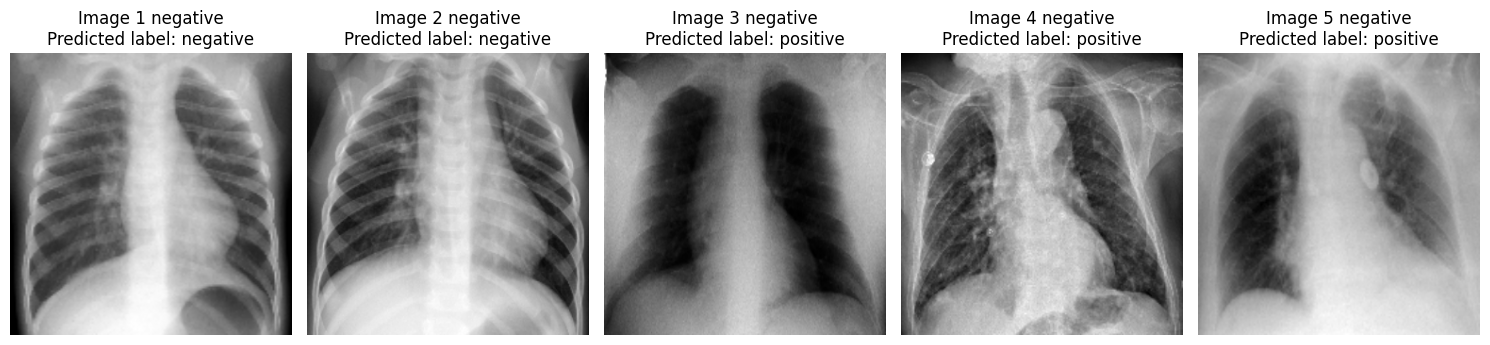

In [ ]:
import matplotlib.pyplot as plt
model=tf.keras.models.load_model(os.path.join(models_dir, 'best_covid_phase2.keras'))
# Assuming you already have the first batch from your data generator
masked_images, labels = test_gen[697]

# Take the first 5 images from the batch
first_five_images = masked_images[:5]
first_five_labels=labels[:5]
preds=model.predict(first_five_images)
preds=np.argmax(preds, axis=1)
preds=[test_gen.label_encoder.classes_[p] for p in preds]
# first_five_labels is shape (batch_size, num_classes), e.g., one-hot vectors

# Convert one-hot vectors to class indices (integers)
label_indices = np.argmax(first_five_labels, axis=1)

# Now inverse transform using integer indices
decoded_labels = train_gen.label_encoder.inverse_transform(label_indices)


plt.figure(figsize=(15, 6))
for i, img in enumerate(first_five_images):
    # img is a NumPy array; no need for .numpy()
    grayscale_img = img.mean(axis=-1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title(f'Image {i+1} {decoded_labels[i]}\nPredicted label: {preds[i]}')
    plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:

only_unfreeze_some=True
# Phase 2: Build model with trainable=True
print("=== PHASE 3: Fine-tuning with more unfrozen layers ===")
model, base_model = build_xception_classifier(num_classes=2, trainable=True)

# Load Phase 1 weights
phase1_weights = os.path.join(models_dir, 'best_covid_phase1.keras')
phase2_weights=os.path.join(models_dir, 'best_covid_phase2.keras')
model.load_weights(phase2_weights)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in base_model.layers[:-10]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

# Compile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Simple callbacks
callbacks = [
    ModelCheckpoint(os.path.join(models_dir, 'best_covid_phase3.keras'),
                   save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Train Phase 2
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("Phase 3 complete!")

=== PHASE 3: Fine-tuning with more unfrozen layers ===
Trainable params: 6,681,346
Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 698s 3s/step - accuracy: 0.7579 - loss: 0.4972 - val_accuracy: 0.5011 - val_loss: 7.3328
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 666s 3s/step - accuracy: 0.8026 - loss: 0.4432 - val_accuracy: 0.5011 - val_loss: 4.6286
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 667s 3s/step - accuracy: 0.7981 - loss: 0.4381 - val_accuracy: 0.5686 - val_loss: 0.9362
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 667s 3s/step - accuracy: 0.8161 - loss: 0.4238 - val_accuracy: 0.6044 - val_loss: 1.5287
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 665s 3s/step - accuracy: 0.8147 - loss: 0.4139 - val_accuracy: 0.8223 - val_loss: 0.3943
Epoch 6/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 664s 2s/step - accuracy: 0.8187 - loss: 0.4080 - val_accuracy: 0.6979 - val_loss: 0.5005
Epoch 7/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 669s 3s/step - accuracy: 0.8296 - loss: 0.3956 - val_accuracy: 0.5917 - val_loss: 1.7714
Epoch 8/20
266

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


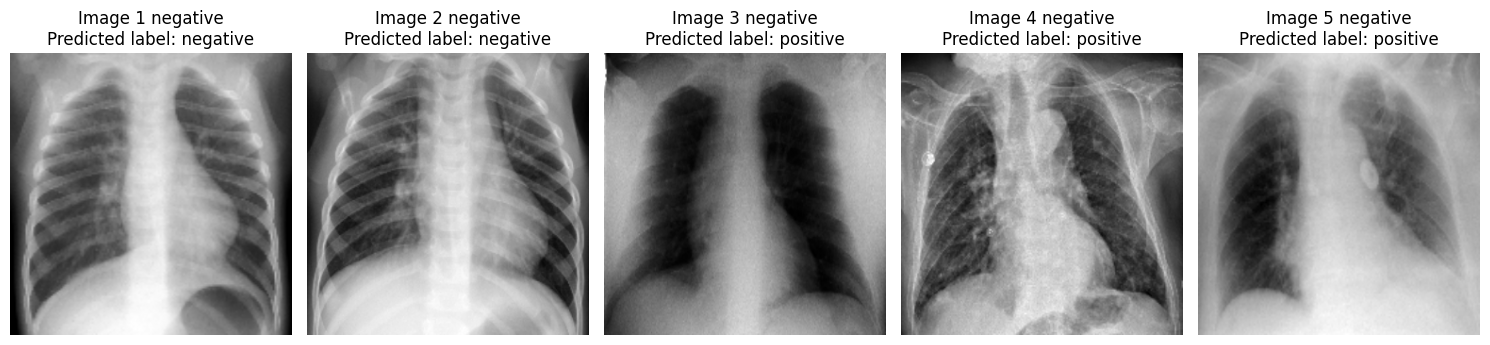

In [ ]:
import matplotlib.pyplot as plt
model=tf.keras.models.load_model(os.path.join(models_dir, 'best_covid_phase3.keras'))
# Assuming you already have the first batch from your data generator
masked_images, labels = test_gen[697]

# Take the first 5 images from the batch
first_five_images = masked_images[:5]
first_five_labels=labels[:5]
preds=model.predict(first_five_images)
preds=np.argmax(preds, axis=1)
preds=[test_gen.label_encoder.classes_[p] for p in preds]
# first_five_labels is shape (batch_size, num_classes), e.g., one-hot vectors

# Convert one-hot vectors to class indices (integers)
label_indices = np.argmax(first_five_labels, axis=1)

# Now inverse transform using integer indices
decoded_labels = train_gen.label_encoder.inverse_transform(label_indices)


plt.figure(figsize=(15, 6))
for i, img in enumerate(first_five_images):
    # img is a NumPy array; no need for .numpy()
    grayscale_img = img.mean(axis=-1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title(f'Image {i+1} {decoded_labels[i]}\nPredicted label: {preds[i]}')
    plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_xception_classifier(num_classes, trainable=False):
    IMAGE_SIZE = (299, 299, 3)

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE
    )
    base_model.trainable = trainable

    inputs = layers.Input(shape=IMAGE_SIZE)
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Add L2
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Add L2
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model, base_model
def get_asymmetric_loss(gamma_pos=0, gamma_neg=4, clip=0.05):
    def loss(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pos_loss = y_true * tf.math.log(y_pred)
        neg_loss = (1 - y_true) * tf.math.log(1 - y_pred)
        if gamma_pos > 0:
            pos_loss *= tf.pow(1 - y_pred, gamma_pos)
        if gamma_neg > 0:
            neg_loss *= tf.pow(y_pred, gamma_neg)
        if clip is not None and clip > 0:
            neg_loss = tf.where(y_pred < clip, 0., neg_loss)
        loss = -(pos_loss + neg_loss)
        return tf.reduce_mean(loss)
    return loss




only_unfreeze_some=True
# Phase 2: Build model with trainable=True
print("=== PHASE 4: Fine-tuning with more unfrozen layers ===")
model, base_model = build_xception_classifier(num_classes=2, trainable=True)

# Load Phase 1 weights
phase1_weights = os.path.join(models_dir, 'best_covid_phase1.keras')
phase3_weights=os.path.join(models_dir, 'best_covid_phase3.keras')
phase4_weights=os.path.join(models_dir, 'best_covid_phase4.keras')
model.load_weights(phase4_weights)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in base_model.layers[:-15]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Simple callbacks
callbacks = [
    ModelCheckpoint(os.path.join(models_dir, 'best_covid_phase4.keras'),
                   save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Train Phase 4
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("Phase 4 complete!")

=== PHASE 4: Fine-tuning with more unfrozen layers ===
Trainable params: 7,973,410


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 743s 3s/step - accuracy: 0.7704 - loss: 0.7886 - precision_2: 0.7704 - recall_2: 0.7704 - val_accuracy: 0.8173 - val_loss: 0.7058 - val_precision_2: 0.8173 - val_recall_2: 0.8173
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 710s 3s/step - accuracy: 0.7847 - loss: 0.7731 - precision_2: 0.7847 - recall_2: 0.7847 - val_accuracy: 0.8067 - val_loss: 0.7139 - val_precision_2: 0.8067 - val_recall_2: 0.8067
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 708s 3s/step - accuracy: 0.7805 - loss: 0.7741 - precision_2: 0.7805 - recall_2: 0.7805 - val_accuracy: 0.8039 - val_loss: 0.7145 - val_precision_2: 0.8039 - val_recall_2: 0.8039
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 702s 3s/step - accuracy: 0.7961 - loss: 0.7576 - precision_2: 0.7961 - recall_2: 0.7961 - val_accuracy: 0.8372 - val_loss: 0.6825 - val_precision_2: 0.8372 - val_recall_2: 0.8372
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 699s 3s/step - accuracy: 0.7958 - loss: 0.7497 - precision_2: 0.7958 - recall_2: 0.7

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


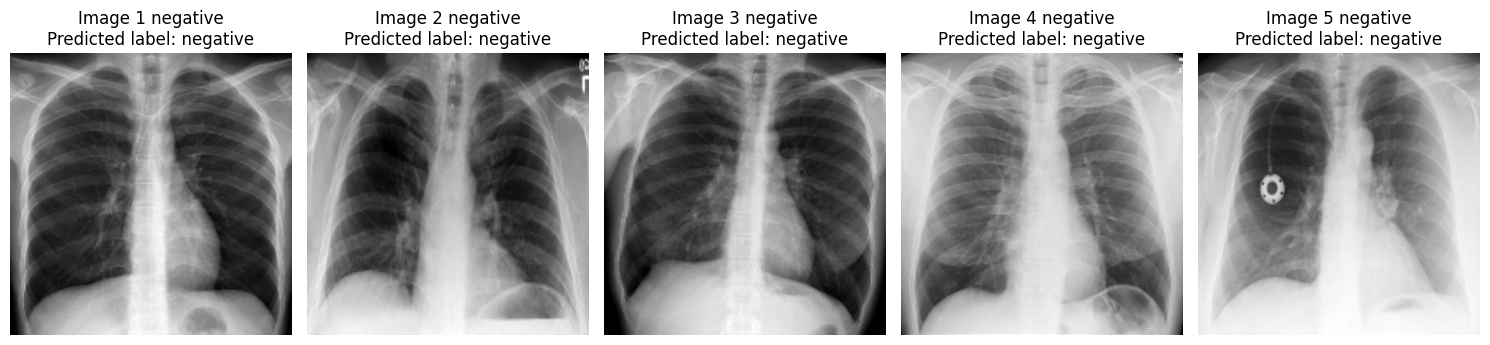

In [ ]:
import matplotlib.pyplot as plt
model=tf.keras.models.load_model(os.path.join(models_dir, 'best_covid_phase3.keras'))
# Assuming you already have the first batch from your data generator
masked_images, labels = val_gen[400]

# Take the first 5 images from the batch
first_five_images = masked_images[:5]
first_five_labels=labels[:5]
preds=model.predict(first_five_images)
preds=np.argmax(preds, axis=1)
preds=[test_gen.label_encoder.classes_[p] for p in preds]
# first_five_labels is shape (batch_size, num_classes), e.g., one-hot vectors

# Convert one-hot vectors to class indices (integers)
label_indices = np.argmax(first_five_labels, axis=1)

# Now inverse transform using integer indices
decoded_labels = train_gen.label_encoder.inverse_transform(label_indices)


plt.figure(figsize=(15, 6))
for i, img in enumerate(first_five_images):
    # img is a NumPy array; no need for .numpy()
    grayscale_img = img.mean(axis=-1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title(f'Image {i+1} {decoded_labels[i]}\nPredicted label: {preds[i]}')
    plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
model=tf.keras.models.load_model(os.path.join(models_dir, 'best_covid_phase4.keras'))

all_predictions = []
all_true_labels = []


for i in range(len(val_gen)):
    imgs, labels = val_gen[i]
    if len(imgs) == 0:
        continue
    preds = model.predict(imgs, verbose=0)
    pred_idx = np.argmax(preds, axis=1)
    true_idx = np.argmax(labels, axis=1)


    all_predictions.extend(pred_idx)
    all_true_labels.extend(true_idx)

import pandas as pd
all_fnames=val_gen.all_filenames
pred_df = pd.DataFrame({
    'filename': all_fnames,
    'true_label_idx': all_true_labels,
    'pred_label_idx': all_predictions,
})

pred_df['true_label'] = val_gen.label_encoder.inverse_transform(pred_df['true_label_idx'])
pred_df['pred_label'] = val_gen.label_encoder.inverse_transform(pred_df['pred_label_idx'])

final_df = val_gen.df.merge(pred_df, on='filename')

In [ ]:
final_df

patient_id  \
0                                  ANON196   
1                                  ANON170   
2                                   S03044   
3                                   S03044   
4                                   S03044   
...                                    ...   
8468  904289e4-96a1-43c8-9eed-6cec2e9c8ddd   
8469  90440659-a140-451d-9ddb-2908d4408c93   
8470  905f015d-8475-463d-aaa6-20953f0edd9e   
8471  90710ba1-7628-4b4c-ac71-a61944ba3825   
8472  9076de25-6b98-422f-9d11-cca443db24b9   

                                               filename     label  source  \
0     CR.1.2.840.113564.1722810170.20200318082923328...  positive  actmed   
1     CR.1.2.840.113564.1722810170.20200320011259312...  positive  actmed   
2     sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...  positive   bimcv   
3     sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...  positive   bimcv   
4     sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...  positive   bimcv   
...                                                 ...       ...     ...   
8468           904289e4-96a1-43c8-9eed-6cec2e9c8ddd.png  negative    rsna   
8469           90440659-a140-451d-9ddb-2908d4408c93.png  negative    rsna   
8470           905f015d-8475-463d-aaa6-20953f0edd9e.png  negative    rsna   
8471           90710ba1-7628-4b4c-ac71-a61944ba3825.png  negative    rsna   
8472           9076de25-6b98-422f-9d11-cca443db24b9.png  negative    rsna   

      label_encoded  true_label_idx  pred_label_idx true_label pred_label  
0                 1               1               1   positive   positive  
1                 1               1               1   positive   positive  
2                 1               1               1   positive   positive  
3                 1               1               1   positive   positive  
4                 1               1               1   positive   positive  
...             ...             ...             ...        ...        ...  
8468              0               0               0   negative   negative  
8469              0               0               0   negative   negative  
8470              0               0               0   negative   negative  
8471              0               0               0   negative   negative  
8472              0               0               0   negative   negative  

[8473 rows x 9 columns]

In [ ]:
def classify_row(row):
    if row['true_label'] == 'positive' and row['pred_label'] == 'positive':
        return 'True Positive'
    elif row['true_label'] == 'negative' and row['pred_label'] == 'negative':
        return 'True Negative'
    elif row['true_label'] == 'negative' and row['pred_label'] == 'positive':
        return 'False Positive'
    elif row['true_label'] == 'positive' and row['pred_label'] == 'negative':
        return 'False Negative'
    else:
        return 'Undefined'  # in case of unexpected labels

final_df['kind'] = final_df.apply(classify_row, axis=1)
grouped_counts = final_df.groupby('source')['kind'].value_counts().unstack(fill_value=0)
grouped_counts

kind        False Negative  False Positive  True Negative  True Positive
source                                                                  
actmed                   0              14             15              2
bimcv                  560             196             61           2591
cohen                    8              25             52             11
fig1                     1               0              0              1
ricord                   3               0              0             59
rsna                     0             293           3576              0
sirm                    48               0              0             17
stonybrook             103               0              0            837

In [ ]:
from sklearn.metrics import f1_score

# Encode string labels to integers for sklearn
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_true_enc = le.fit_transform(final_df['true_label'])
y_pred_enc = le.transform(final_df['pred_label'])

# Calculate F1 score, weighted average to account for class imbalance
f1 = f1_score(y_true_enc, y_pred_enc, average='weighted')

print(f"Weighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.8523


Plotting False Negatives for source: bimcv, count: 560


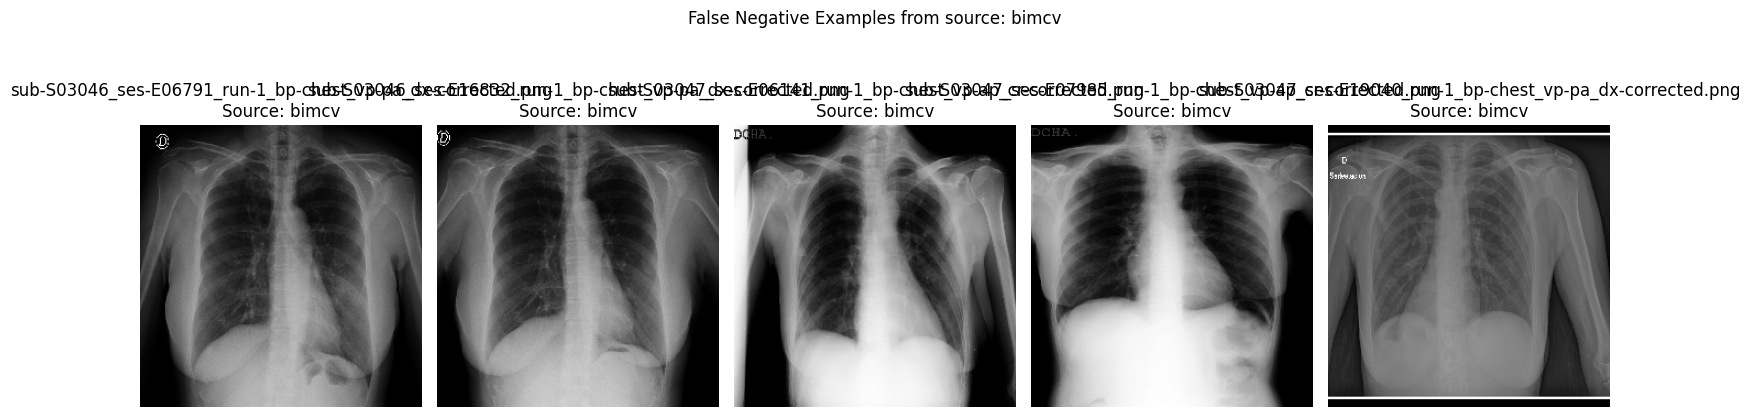

Plotting False Negatives for source: cohen, count: 8


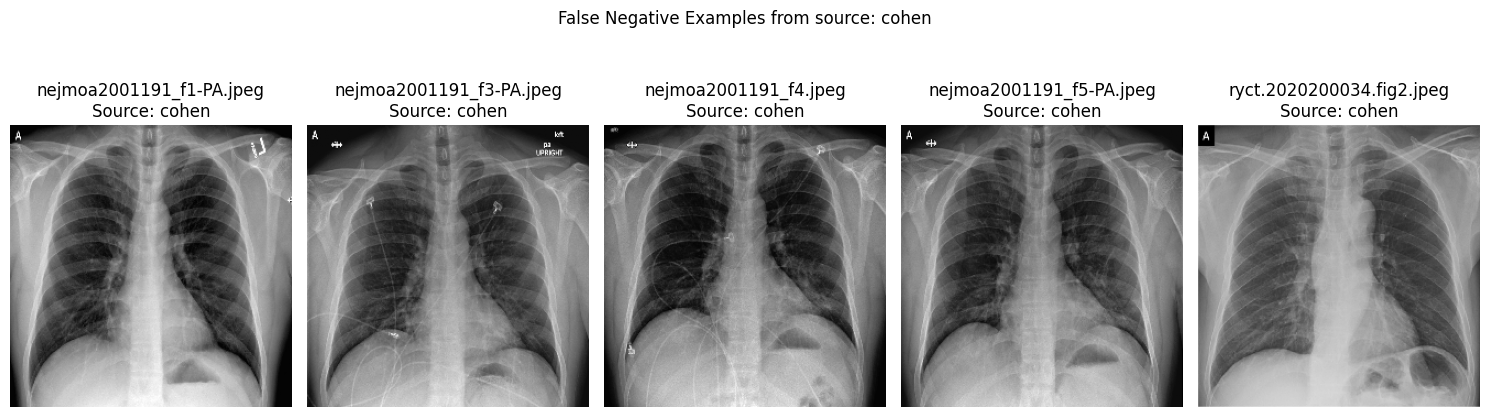

Plotting False Negatives for source: fig1, count: 1


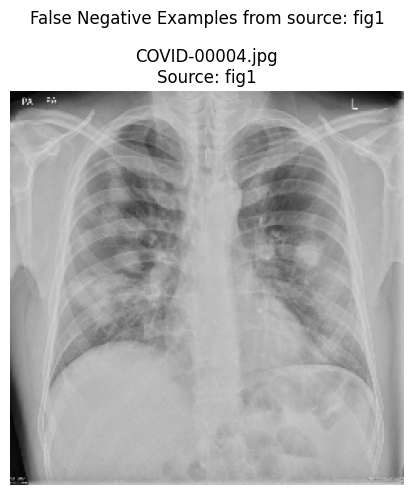

Plotting False Negatives for source: ricord, count: 3


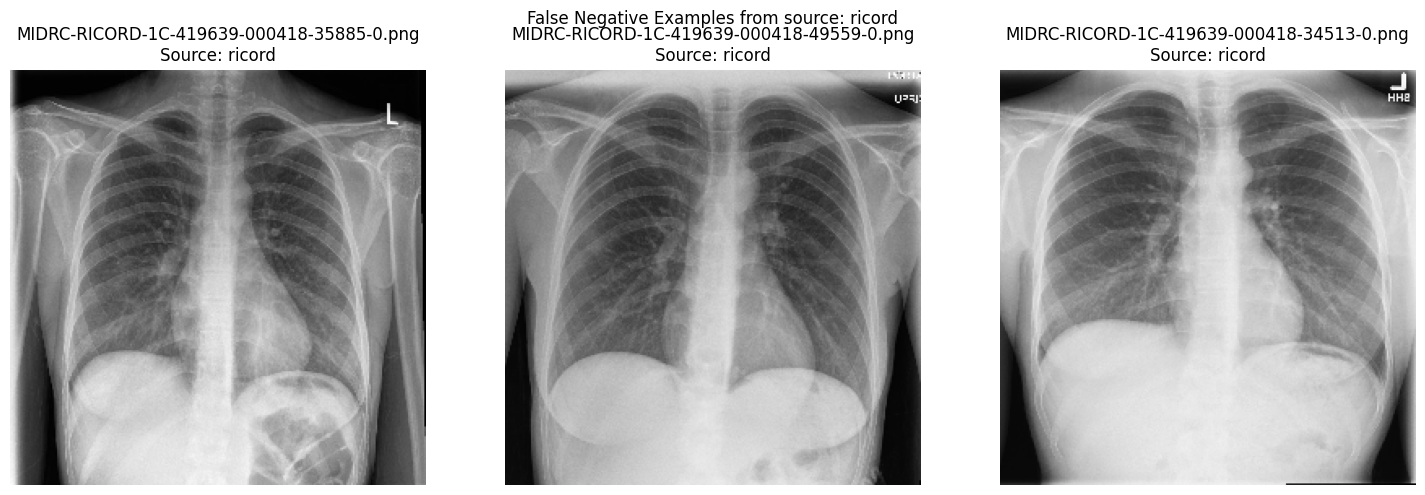

Plotting False Negatives for source: sirm, count: 48


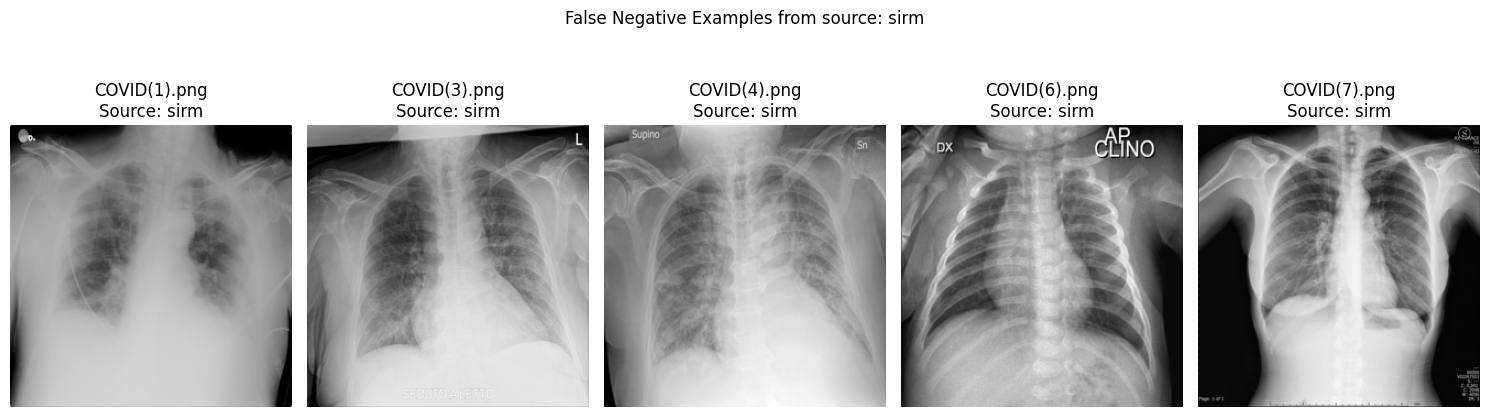

Plotting False Negatives for source: stonybrook, count: 103


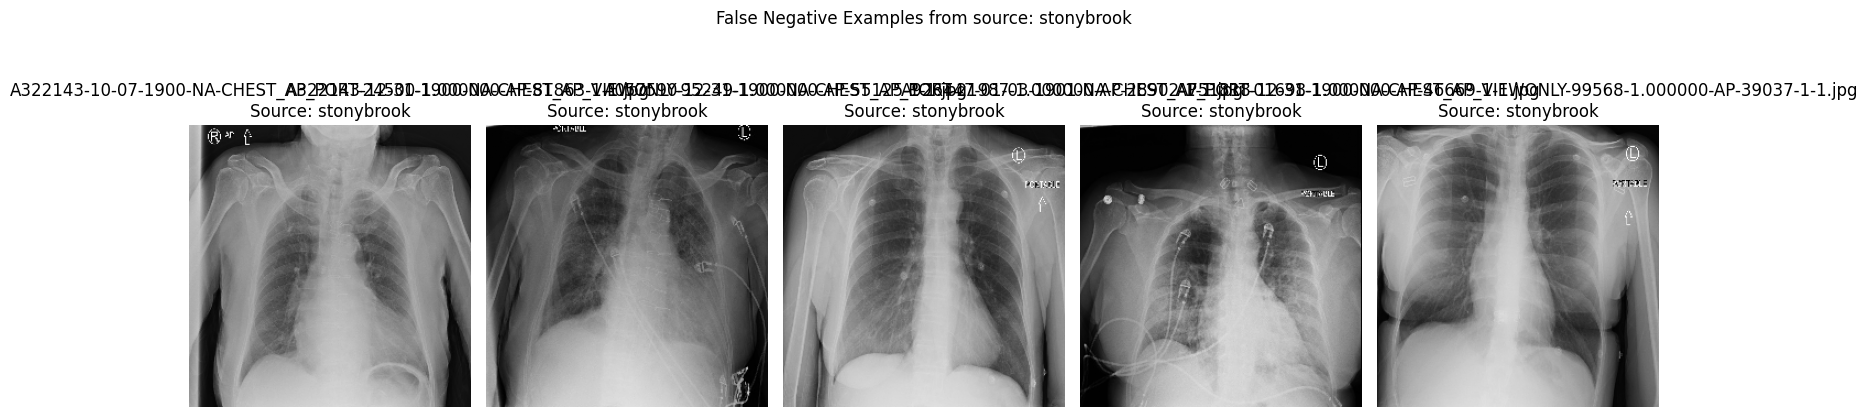

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

def plot_false_negatives(df, val_gen, max_images=5):
    # Filter false negatives
    fn_df = df[df['kind'] == 'False Negative']

    # Group by source
    grouped = fn_df.groupby('source')

    for source, group in grouped:
        print(f"Plotting False Negatives for source: {source}, count: {len(group)}")
        fig, axes = plt.subplots(1, min(len(group), max_images), figsize=(15, 5))
        if min(len(group), max_images) == 1:
            axes = [axes]
        for i, (idx, row) in enumerate(group.head(max_images).iterrows()):
            img_path = os.path.join(val_gen.img_dir, row['filename'])
            if not os.path.exists(img_path):
                print(f"Image not found: {img_path}")
                continue
            # Load image, convert to array
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=val_gen.img_size, color_mode='grayscale')
            img_array = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0

            axes[i].imshow(img_array, cmap='gray')
            axes[i].set_title(f"{row['filename']}\nSource: {source}")
            axes[i].axis('off')

        plt.suptitle(f"False Negative Examples from source: {source}")
        plt.tight_layout()
        plt.show()
plot_false_negatives(final_df, val_gen, max_images=5)


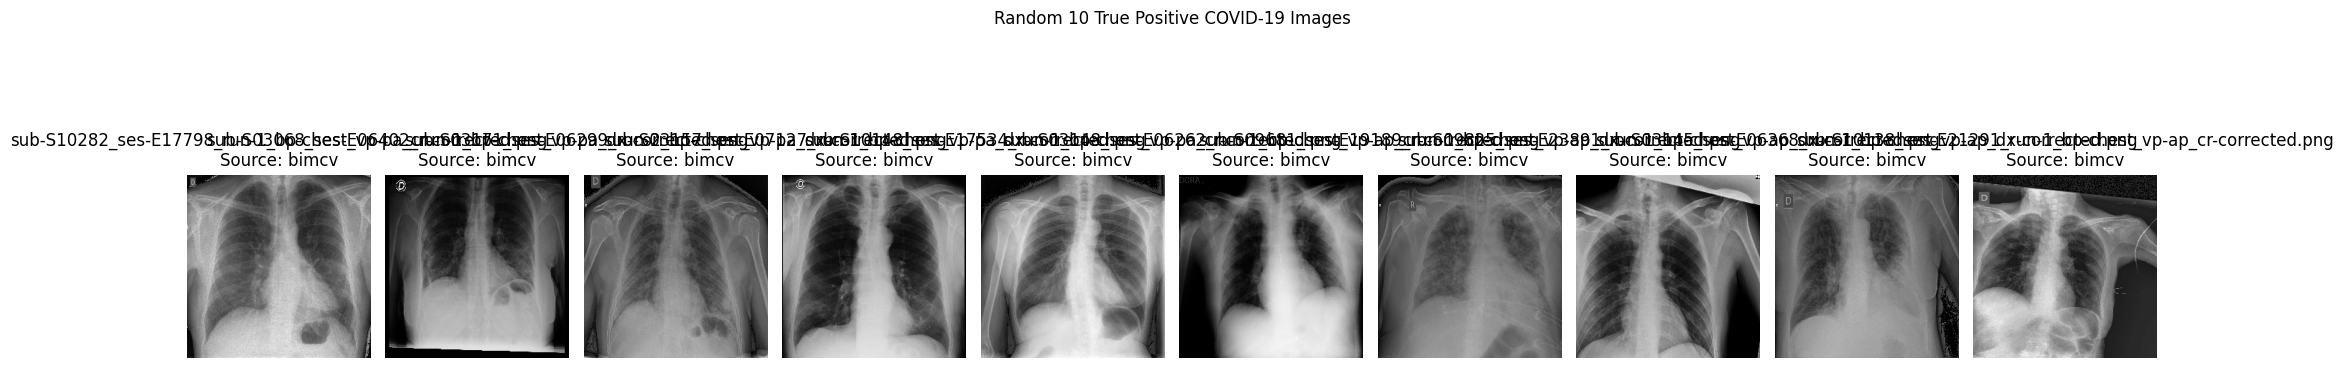

In [ ]:
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

def plot_random_true_positives(final_df, val_gen, num_images=10):
    # Filter True Positives
    tp_df = final_df[final_df['kind'] == 'True Positive']

    # Randomly sample desired number of images
    sample_df = tp_df.sample(n=min(num_images, len(tp_df)), random_state=42)

    fig, axes = plt.subplots(1, len(sample_df), figsize=(20, 5))
    if len(sample_df) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, sample_df.iterrows()):
        img_path = os.path.join(val_gen.img_dir, row['filename'])
        if not os.path.exists(img_path):
            ax.set_title(f"{row['filename']}\nImage not found")
            ax.axis('off')
            continue

        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=val_gen.img_size)
        img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0

        ax.imshow(img_arr, cmap='gray')
        ax.set_title(f"{row['filename']}\nSource: {row['source']}")
        ax.axis('off')

    plt.suptitle(f"Random {len(sample_df)} True Positive COVID-19 Images")
    plt.tight_layout()
    plt.show()

# Usage
plot_random_true_positives(final_df, val_gen, num_images=10)


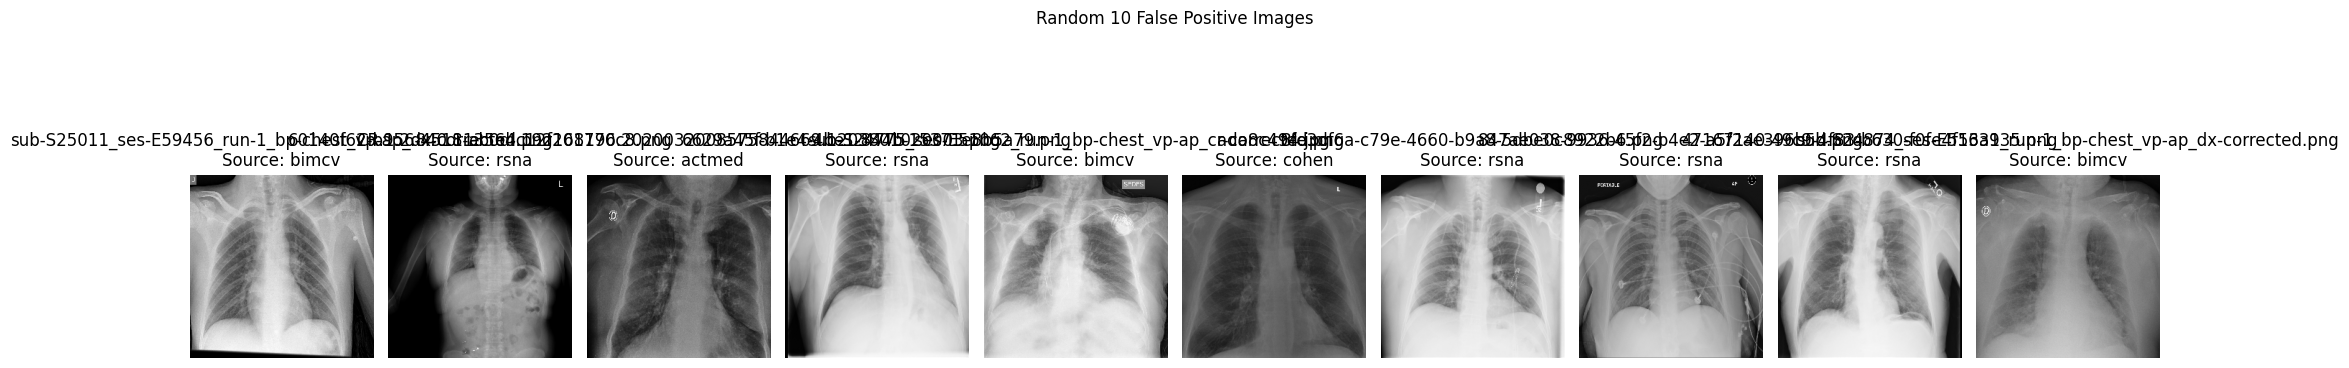

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

def plot_random_false_positives(final_df, val_gen, num_images=10):
    # Filter False Positives
    fp_df = final_df[final_df['kind'] == 'False Positive']

    # Randomly sample num_images
    sample_df = fp_df.sample(n=min(num_images, len(fp_df)), random_state=42)

    fig, axes = plt.subplots(1, len(sample_df), figsize=(20, 5))
    if len(sample_df) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, sample_df.iterrows()):
        img_path = os.path.join(val_gen.img_dir, row['filename'])
        if not os.path.exists(img_path):
            ax.set_title(f"{row['filename']}\nNot found")
            ax.axis('off')
            continue

        img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=val_gen.img_size)
        img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0

        ax.imshow(img_arr, cmap='gray')
        ax.set_title(f"{row['filename']}\nSource: {row['source']}")
        ax.axis('off')

    plt.suptitle(f"Random {len(sample_df)} False Positive Images")
    plt.tight_layout()
    plt.show()

# Usage
plot_random_false_positives(final_df, val_gen, num_images=10)


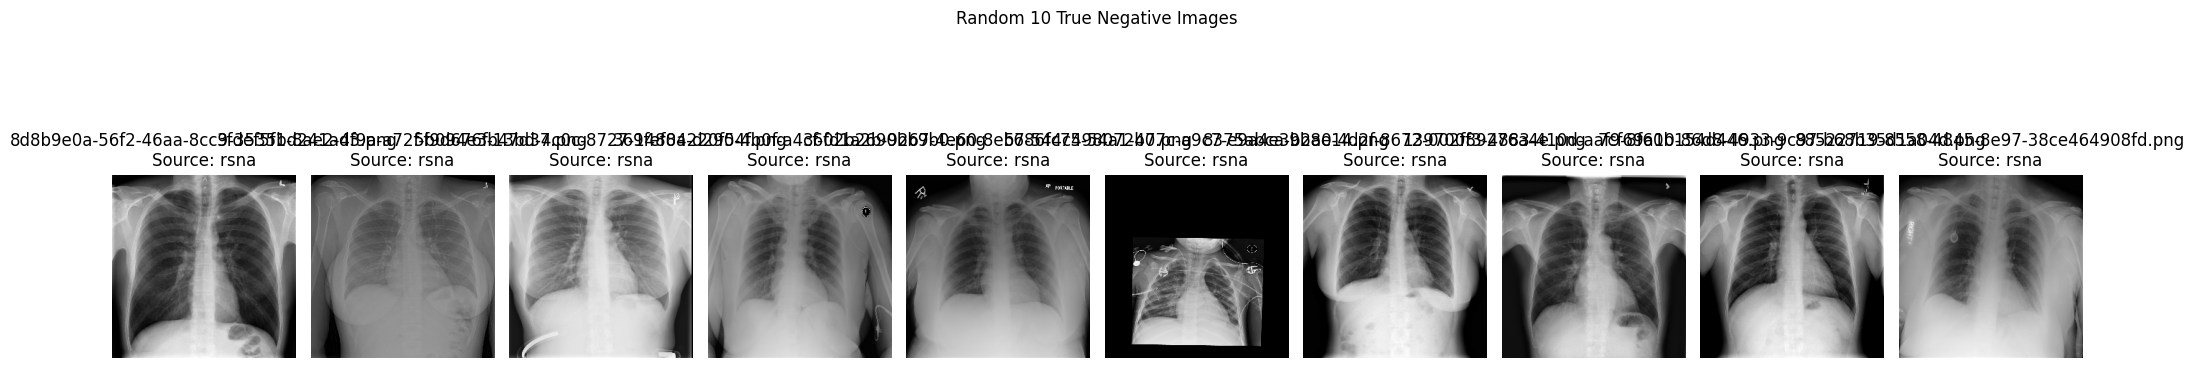

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

def plot_random_true_negatives(final_df, val_gen, num_images=10):
    # Filter True Negatives
    tn_df = final_df[final_df['kind'] == 'True Negative']

    # Randomly sample num_images
    sample_df = tn_df.sample(n=min(num_images, len(tn_df)), random_state=42)

    fig, axes = plt.subplots(1, len(sample_df), figsize=(20, 5))
    if len(sample_df) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, sample_df.iterrows()):
        img_path = os.path.join(val_gen.img_dir, row['filename'])
        if not os.path.exists(img_path):
            ax.set_title(f"{row['filename']}\nImage not found")
            ax.axis('off')
            continue

        img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=val_gen.img_size)
        img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0

        ax.imshow(img_arr, cmap='gray')
        ax.set_title(f"{row['filename']}\nSource: {row['source']}")
        ax.axis('off')

    plt.suptitle(f"Random {len(sample_df)} True Negative Images")
    plt.tight_layout()
    plt.show()

# Usage
plot_random_true_negatives(final_df, val_gen, num_images=10)


In [ ]:
train_gen.df

patient_id  \
0                                  S324773   
1                                  S313424   
2     ec755d65-c3e4-427f-b7fc-7a596cf8fbb2   
3                                  A097839   
4                                  S326264   
...                                    ...   
8526  916de1f3-688e-4d39-bd41-db3f653e90b8   
8527                               S326687   
8528                                S11009   
8529                               S314986   
8530  152f5cd9-cc37-4312-befb-1b036cb68c82   

                                               filename     label      source  \
0     sub-S324773_ses-E49839_run-1_bp-chest_vp-pa_cr...  positive       bimcv   
1     sub-S313424_ses-E29058_run-1_bp-chest_vp-ap_dx...  positive       bimcv   
2              ec755d65-c3e4-427f-b7fc-7a596cf8fbb2.png  negative        rsna   
3     A097839-01-03-1901-NA-CHEST_AP_PORT-75044-2.00...  positive  stonybrook   
4     sub-S326264_ses-E52700_run-1_bp-chest_vp-pa_dx...  positive       bimcv   
...                                                 ...       ...         ...   
8526           916de1f3-688e-4d39-bd41-db3f653e90b8.png  negative        rsna   
8527  sub-S326687_ses-E54202_run-1_bp-chest_vp-pa_dx...  positive       bimcv   
8528  sub-S11009_ses-E19277_run-1_bp-chest_vp-ap_dx-...  positive       bimcv   
8529  sub-S314986_ses-E33609_run-1_bp-chest_vp-ap_dx...  positive       bimcv   
8530           152f5cd9-cc37-4312-befb-1b036cb68c82.png  negative        rsna   

      label_encoded  
0                 1  
1                 1  
2                 0  
3                 1  
4                 1  
...             ...  
8526              0  
8527              1  
8528              1  
8529              1  
8530              0  

[8531 rows x 5 columns]

In [ ]:
lung_seg_utils.retrieve_and_process_data()
main_dir='/content/data'


base=os.path.join(main_dir,"COVID-19_Radiography_Dataset")
subfolders=['Normal','COVID','Viral Pneumonia','Lung_Opacity']
S=0
size_dict={}
for folder in subfolders:
    print(folder)
    print( f'\tSize: {len(os.listdir(os.path.join(base,folder,"masks")))}')
    size_dict[folder]=len(os.listdir(os.path.join(base,folder,"masks")))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from COVID-19_Radiography_Dataset.zip to /content/data
Normal
	Size: 10192
COVID
	Size: 3616
Viral Pneumonia
	Size: 1345
Lung_Opacity
	Size: 6012


In [2]:
paths = [
        (os.path.join(base, 'Lung_Opacity', 'images'), os.path.join(base, 'Lung_Opacity', 'masks')),
        (os.path.join(base, 'Normal', 'images'), os.path.join(base, 'Normal', 'masks')),
        (os.path.join(base, 'COVID', 'images'), os.path.join(base, 'COVID', 'masks')),
        (os.path.join(base, 'Viral Pneumonia', 'images'), os.path.join(base, 'Viral Pneumonia', 'masks'))
    ]

image_fnames=[]
mask_fnames=[]
dirs=[]
mask_dir=[]

for image_directory, mask_directory in paths:
    for image_filename, mask_filename in zip(sorted(os.listdir(image_directory)), sorted(os.listdir(mask_directory))):
        image_fnames.append(image_filename)
        mask_fnames.append(mask_filename)
        dirs.append(image_directory)
        mask_dir.append(mask_directory)
fnames_df=pd.DataFrame({'Image_Filename':image_fnames,'Mask_Filename': mask_fnames,'Image_Directory':dirs,'Mask_Directory':mask_dir})
train_fnames,test_set=train_test_split(fnames_df,stratify=fnames_df['Image_Directory'],test_size=0.20,random_state=42)
#train_fnames,val_fnames=train_test_split(train_fnames,stratify=train_fnames['Image_Directory'],test_size=0.20,random_state=42)
train_fnames['binary_label']=train_fnames['Image_Filename'].apply(lambda x: 1 if 'COVID' in x else 0)
#val_fnames['binary_label']=val_fnames['Image_Filename'].apply(lambda x: 1 if 'COVID' in x else 0)
test_set['binary_label']=test_set['Image_Filename'].apply(lambda x: 1 if 'COVID' in x else 0)

NameError: name 'base' is not defined

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.preprocessing import LabelEncoder
import joblib

class COVIDxMaskedImageGeneratorC19RD(tf.keras.utils.Sequence):
    def __init__(self, df, unet_model, project_dir, batch_size=32, img_size=(256,256), shuffle=True, augment=False, is_train=False):
        """
        df: pd.DataFrame with at least columns ['Image_Filename', 'Image_Directory', 'binary_label']
        unet_model: U-Net model for mask generation
        project_dir: directory for saving/loading LabelEncoder
        """
        self.df = df.reset_index(drop=True)
        self.unet_model = unet_model
        self.project_dir = project_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.is_train = is_train
        self.all_filenames = []

        # Build label encoder or load if exists
        label_encoder_path = os.path.join(project_dir, 'label_encoder.joblib')
        if os.path.exists(label_encoder_path):
            self.label_encoder = joblib.load(label_encoder_path)
            print(f"Loaded label encoder from {label_encoder_path}")
        else:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.df['binary_label'])
            joblib.dump(self.label_encoder, label_encoder_path)

        # Store encoded labels
        self.df['label_encoded'] = self.label_encoder.transform(self.df['binary_label'])

        if self.augment:
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=2,
                zoom_range=0.05,
                horizontal_flip=True,
                width_shift_range=0.02,
                height_shift_range=0.02,
                fill_mode='constant',
                cval=0.0
            )
        else:
            self.datagen = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def crop_to_mask_with_padding(self, img, mask, padding=10):
        coords = np.argwhere(mask > 0)
        if coords.size == 0:
            return cv2.resize(img, (self.img_size[1], self.img_size[0]))
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
        y0 = max(y0 - padding, 0)
        x0 = max(x0 - padding, 0)
        y1 = min(y1 + padding, img.shape[0])
        x1 = min(x1 + padding, img.shape[1])
        return img[y0:y1, x0:x1]

    def resize_and_convert_to_rgb(self, img_array, target_size=(299, 299, 3)):
        if len(img_array.shape) == 3 and img_array.shape[-1] == 1:
            img_array = np.squeeze(img_array, axis=-1)
        resized_img = cv2.resize(img_array, (target_size[1], target_size[0]))
        if len(resized_img.shape) == 2:
            resized_img = np.stack([resized_img]*3, axis=-1)
        return resized_img

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        imgs = []
        labels = []
        self.all_filenames = []

        for idx in batch_indices:
            row = self.df.iloc[idx]
            img_path = os.path.join(row['Image_Directory'], row['Image_Filename'])
            if not os.path.exists(img_path):
                print(f"Warning: File not found: {img_path}")
                continue

            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size, color_mode='grayscale')
            img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0

            imgs.append(img_arr)
            labels.append(row['label_encoded'])
            self.all_filenames.append(row['Image_Filename'])

        if len(imgs) == 0:
            return np.array([]), np.array([])

        imgs_np = np.array(imgs, dtype=np.float32)
        imgs_tf = tf.convert_to_tensor(imgs_np[..., np.newaxis], dtype=tf.float32)

        pred_masks = self.unet_model.predict(imgs_tf, verbose=0)
        pred_masks = (pred_masks > 0.5).astype(np.float32)

        masked_cropped_imgs = []
        for i in range(len(imgs_np)):
            cropped_img = self.crop_to_mask_with_padding(imgs_np[i], pred_masks[i].squeeze(), padding=10)
            resized_img = self.resize_and_convert_to_rgb(cropped_img, target_size=(299, 299, 3))
            masked_cropped_imgs.append(resized_img)

        masked_cropped_imgs = np.array(masked_cropped_imgs, dtype=np.float32)

        if self.augment and self.datagen is not None:
            augmented_imgs = []
            for img in masked_cropped_imgs:
                augmented_img = self.datagen.random_transform(img)
                augmented_imgs.append(augmented_img)
            masked_cropped_imgs = np.array(augmented_imgs, dtype=np.float32)

        final_imgs = preprocess_input(masked_cropped_imgs)
        labels_categorical = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_encoder.classes_))

        return final_imgs, labels_categorical
# Assume you have your unet_model loaded already and project_dir defined
model_path = os.path.join(models_dir, 'generator_gan_model_run2.keras')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"U-Net model not found at: {model_path}")
train_fnames['binary_label']=train_fnames['Image_Filename'].apply(lambda x: 'positive' if 'COVID' in x else 'negative')
generator_unet = tf.keras.models.load_model(model_path)
train_gen = COVIDxMaskedImageGeneratorC19RD(
    df=train_fnames,               # Your DataFrame with columns 'Image_Filename', 'Image_Directory', 'binary_label'
    unet_model=generator_unet,    # Your preloaded U-Net model
    project_dir=project_dir,       # Directory to save/load label encoder
    batch_size=32,                 # Or your preferred batch size
    img_size=(256, 256),           # Your preprocessing size for U-Net and cropping
    shuffle=True,
    augment=True,
    is_train=True
)


Loaded label encoder from /content/drive/MyDrive/Covid-19_Presence/label_encoder.joblib


In [ ]:
# Just get one batch
masked_images, labels = train_gen[0]

print("Batch masked_images shape:", masked_images.shape)  # Should be (batch_size, 299, 299, 3)
print("Batch labels shape:", labels.shape)

# Print individual shapes if needed
for i in range(min(10, masked_images.shape[0])):
    print(f"Image {i} shape:", masked_images[i].shape)  # Should be (299, 299, 3)
    print(f"Label {i} shape:", labels[i])  # Should be (2,)


Batch masked_images shape: (32, 299, 299, 3)
Batch labels shape: (32, 2)
Image 0 shape: (299, 299, 3)
Label 0 shape: [1. 0.]
Image 1 shape: (299, 299, 3)
Label 1 shape: [0. 1.]
Image 2 shape: (299, 299, 3)
Label 2 shape: [0. 1.]
Image 3 shape: (299, 299, 3)
Label 3 shape: [1. 0.]
Image 4 shape: (299, 299, 3)
Label 4 shape: [1. 0.]
Image 5 shape: (299, 299, 3)
Label 5 shape: [1. 0.]
Image 6 shape: (299, 299, 3)
Label 6 shape: [1. 0.]
Image 7 shape: (299, 299, 3)
Label 7 shape: [0. 1.]
Image 8 shape: (299, 299, 3)
Label 8 shape: [0. 1.]
Image 9 shape: (299, 299, 3)
Label 9 shape: [1. 0.]


In [ ]:
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_xception_classifier(num_classes, trainable=False):
    IMAGE_SIZE = (299, 299, 3)

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE
    )
    base_model.trainable = trainable

    inputs = layers.Input(shape=IMAGE_SIZE)
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Add L2
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Add L2
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model, base_model
def get_asymmetric_loss(gamma_pos=0, gamma_neg=4, clip=0.05):
    def loss(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pos_loss = y_true * tf.math.log(y_pred)
        neg_loss = (1 - y_true) * tf.math.log(1 - y_pred)
        if gamma_pos > 0:
            pos_loss *= tf.pow(1 - y_pred, gamma_pos)
        if gamma_neg > 0:
            neg_loss *= tf.pow(y_pred, gamma_neg)
        if clip is not None and clip > 0:
            neg_loss = tf.where(y_pred < clip, 0., neg_loss)
        loss = -(pos_loss + neg_loss)
        return tf.reduce_mean(loss)
    return loss




only_unfreeze_some=True
# Phase 2: Build model with trainable=True
print("=== PHASE 5: Different Data Source for training and Unfreeze 1 more layer ===")
model, base_model = build_xception_classifier(num_classes=2, trainable=True)

# Load Phase 1 weights
phase1_weights = os.path.join(models_dir, 'best_covid_phase1.keras')
phase3_weights=os.path.join(models_dir, 'best_covid_phase3.keras')
phase4_weights=os.path.join(models_dir, 'best_covid_phase4.keras')
model.load_weights(phase4_weights)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in base_model.layers[:-16]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")



model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Simple callbacks
callbacks = [
    ModelCheckpoint(os.path.join(models_dir, 'best_covid_phase5.keras'),
                   save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Train Phase 5
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

print("Phase 5 complete!")

=== PHASE 5: Different Data Source for training and Unfreeze 1 more layer ===
Trainable params: 7,973,410
Epoch 1/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 1073s 2s/step - accuracy: 0.7001 - loss: 0.8602 - val_accuracy: 0.7280 - val_loss: 0.7932
Epoch 2/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 1008s 2s/step - accuracy: 0.8306 - loss: 0.6844 - val_accuracy: 0.6887 - val_loss: 0.8499
Epoch 3/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 1002s 2s/step - accuracy: 0.8522 - loss: 0.6620 - val_accuracy: 0.7925 - val_loss: 0.7277
Epoch 4/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 1002s 2s/step - accuracy: 0.8531 - loss: 0.6579 - val_accuracy: 0.8206 - val_loss: 0.7130
Epoch 5/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.8619 - loss: 0.6461 - val_accuracy: 0.8205 - val_loss: 0.7071
Phase 5 complete!


In [ ]:
import tensorflow as tf
import os

class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_accuracy', mode='max', initial_best=0.0):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = initial_best
        self.compare = max if mode == 'max' else min

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        if self.compare(current, self.best) == current:
            print(f"Epoch {epoch +1}: {self.monitor} improved from {self.best:.4f} to {current:.4f}, saving model.")
            self.best = current
            self.model.save(self.filepath)
train_gen1, val_gen, test_gen = create_generators(
      path=path,
      models_dir=models_dir,
      project_dir=project_dir
  )
model_path = os.path.join(models_dir, 'generator_gan_model_run2.keras')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"U-Net model not found at: {model_path}")
train_fnames['binary_label']=train_fnames['Image_Filename'].apply(lambda x: 'positive' if 'COVID' in x else 'negative')
generator_unet = tf.keras.models.load_model(model_path)
train_gen2 = COVIDxMaskedImageGeneratorC19RD(
    df=train_fnames,               # Your DataFrame with columns 'Image_Filename', 'Image_Directory', 'binary_label'
    unet_model=generator_unet,    # Your preloaded U-Net model
    project_dir=project_dir,       # Directory to save/load label encoder
    batch_size=32,                 # Or your preferred batch size
    img_size=(256, 256),           # Your preprocessing size for U-Net and cropping
    shuffle=True,
    augment=True,
    is_train=True
)

only_unfreeze_some=True
# Phase 2: Build model with trainable=True
print("=== PHASE 6: Combine Data Sources and Unfreeze 1 more layer ===")
model, base_model = build_xception_classifier(num_classes=2, trainable=True)


# Load Phase 5 weights
phase5_weights=os.path.join(models_dir, 'best_covid_phase5.keras')
model.load_weights(phase5_weights)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in base_model.layers[:-17]:
      layer.trainable = False
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    CustomModelCheckpoint(os.path.join(models_dir, 'best_covid_phase6.keras'),
                        monitor='val_accuracy', mode='max', initial_best=0.8270),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")
epochs=10
for i in range(epochs):
    # Train Phase 6
  train_generator=random.choice([train_gen1,train_gen2])
  history_phase6 = model.fit(
      train_generator,
      validation_data=val_gen,
      epochs=1,
      callbacks=callbacks,
      verbose=1
  )

print("Phase 6 complete!")


Loaded label encoder from /content/drive/MyDrive/Covid-19_Presence/label_encoder.joblib
=== PHASE 6: Combine Data Sources and Unfreeze 1 more layer ===
Trainable params: 7,973,410


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 1062s 2s/step - accuracy: 0.8659 - loss: 0.6433 - val_accuracy: 0.8100 - val_loss: 0.7096
530/530 ━━━━━━━━━━━━━━━━━━━━ 1005s 2s/step - accuracy: 0.8698 - loss: 0.6277 - val_accuracy: 0.8205 - val_loss: 0.7199
530/530 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.8669 - loss: 0.6259 - val_accuracy: 0.7566 - val_loss: 0.7774
267/267 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.7136 - loss: 0.9437 - val_accuracy: 0.8095 - val_loss: 0.7549
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7865 - loss: 0.7730Epoch 1: val_accuracy improved from 0.8270 to 0.8367, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.7866 - loss: 0.7729 - val_accuracy: 0.8367 - val_loss: 0.6710
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8077 - loss: 0.7313Epoch 1: val_accuracy improved from 0.8367 to 0.8539, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.8077 - loss: 0.7313 - val_accuracy: 0.8539 - val_loss: 0.6520
530/530 

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


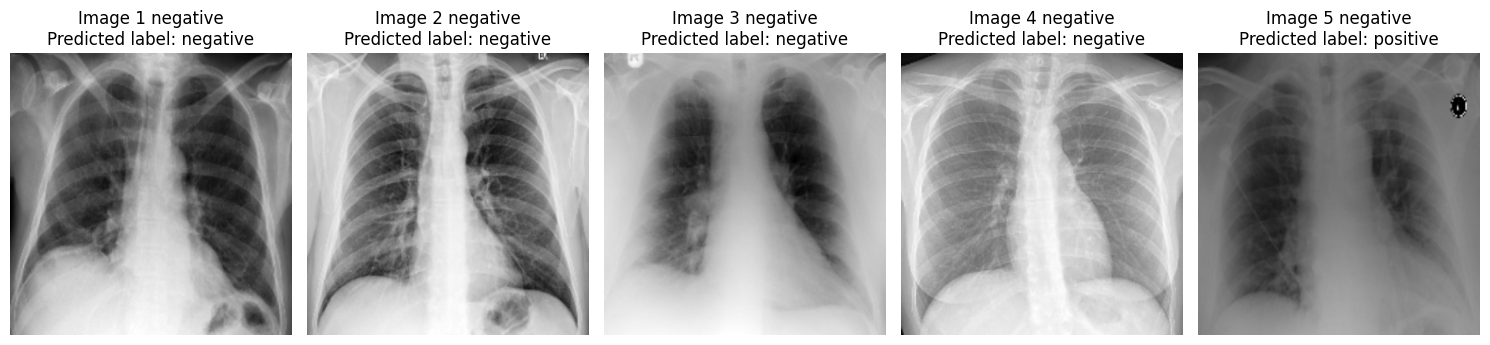

In [ ]:
import matplotlib.pyplot as plt
model=tf.keras.models.load_model(os.path.join(models_dir, 'best_covid_phase6.keras'))
# Assuming you already have the first batch from your data generator
masked_images, labels = val_gen[369]

# Take the first 5 images from the batch
first_five_images = masked_images[:5]
first_five_labels=labels[:5]
preds=model.predict(first_five_images)
preds=np.argmax(preds, axis=1)
preds=[test_gen.label_encoder.classes_[p] for p in preds]
# first_five_labels is shape (batch_size, num_classes), e.g., one-hot vectors

# Convert one-hot vectors to class indices (integers)
label_indices = np.argmax(first_five_labels, axis=1)

# Now inverse transform using integer indices
decoded_labels = train_gen.label_encoder.inverse_transform(label_indices)


plt.figure(figsize=(15, 6))
for i, img in enumerate(first_five_images):
    # img is a NumPy array; no need for .numpy()
    grayscale_img = img.mean(axis=-1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title(f'Image {i+1} {decoded_labels[i]}\nPredicted label: {preds[i]}')
    plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
train_gen.df['binary_label'].value_counts()

binary_label
negative    14039
positive     2893
Name: count, dtype: int64

In [ ]:
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_xception_classifier(num_classes, trainable=False):
    IMAGE_SIZE = (299, 299, 3)

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE
    )
    base_model.trainable = trainable

    inputs = layers.Input(shape=IMAGE_SIZE)
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Add L2
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Add L2
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model, base_model
def get_asymmetric_loss(gamma_pos=0, gamma_neg=4, clip=0.05):
    def loss(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pos_loss = y_true * tf.math.log(y_pred)
        neg_loss = (1 - y_true) * tf.math.log(1 - y_pred)
        if gamma_pos > 0:
            pos_loss *= tf.pow(1 - y_pred, gamma_pos)
        if gamma_neg > 0:
            neg_loss *= tf.pow(y_pred, gamma_neg)
        if clip is not None and clip > 0:
            neg_loss = tf.where(y_pred < clip, 0., neg_loss)
        loss = -(pos_loss + neg_loss)
        return tf.reduce_mean(loss)
    return loss




only_unfreeze_some=False
# Phase 2: Build model with trainable=True
print("=== PHASE 7: Fine-tuning with more unfrozen layers ===")
model, base_model = build_xception_classifier(num_classes=2, trainable=True)

# Load Phase 4 weights

phase4_weights=os.path.join(models_dir, 'best_covid_phase4.keras')
model.load_weights(phase4_weights)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in base_model.layers[:-15]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")



model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Simple callbacks
callbacks = [
    ModelCheckpoint(os.path.join(models_dir, 'best_covid_phase7.keras'),
                   save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Train Phase 4
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("Phase 7 complete!")

=== PHASE 7: Fine-tuning with more unfrozen layers ===
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Trainable params: 21,991,978


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1150s 4s/step - accuracy: 0.5899 - loss: 2.2732 - val_accuracy: 0.5306 - val_loss: 2.1218
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - accuracy: 0.6640 - loss: 1.7597 - val_accuracy: 0.6243 - val_loss: 1.8427
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 788s 3s/step - accuracy: 0.7163 - loss: 1.5944 - val_accuracy: 0.7278 - val_loss: 1.2822
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 787s 3s/step - accuracy: 0.7235 - loss: 1.4049 - val_accuracy: 0.7264 - val_loss: 1.1847
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 781s 3s/step - accuracy: 0.7431 - loss: 1.3328 - val_accuracy: 0.6586 - val_loss: 1.5220
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - accuracy: 0.7631 - loss: 1.2651 - val_accuracy: 0.7003 - val_loss: 1.1759
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 790s 3s/step - accuracy: 0.7767 - loss: 1.1694 - val_accuracy: 0.7320 - val_loss: 1.0977
Epoch 8/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 788s 3s/step - accuracy: 0.7950 - loss: 1.0846 - val_acc

In [ ]:
import tensorflow as tf

# Load the full model that includes the Xception base and the MLP head
full_model = tf.keras.models.load_model(os.path.join(models_dir, 'best_covid_phase6.keras'))

# This will print the full architecture, confirming it includes the MLP layers
full_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,997,424 (144.95 MB)

 Trainable params: 7,973,410 (30.42 MB)

 Non-trainable params: 14,077,192 (53.70 MB)

 Optimizer params: 15,946,822 (60.83 MB)

In [ ]:
from tensorflow.keras.models import Model

# Get the base model layer by its name from the full model
xception_base = full_model.get_layer('xception')

# Create a new feature extractor model using the base model's input and output
feature_extractor = Model(inputs=xception_base.input, outputs=xception_base.output)

# This will show the summary of only the Xception base, without the MLP head
feature_extractor.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_10[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_60[0][0]    

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 6,788,384 (25.90 MB)

 Non-trainable params: 14,073,096 (53.68 MB)

In [ ]:
# Get the weights from the feature extractor model
base_weights = feature_extractor.get_weights()

# Save the weights to a file
weights_path = os.path.join(models_dir, 'xception_base.weights.h5')
feature_extractor.save_weights(weights_path)

print(f"Base model weights saved to {weights_path}")

Base model weights saved to /content/drive/MyDrive/Covid-19_Presence/models/xception_base.weights.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
import os

def build_new_feature_extractor():
    # Build the exact same Xception base model architecture
    base_model = Xception(
        weights=None,  # Do not load 'imagenet' weights here
        include_top=False,
        input_shape=(299, 299, 3)
    )

    # Create the feature extractor model
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    return feature_extractor

feature_extractor_model = build_new_feature_extractor()
# The path where you saved the weights
weights_path = os.path.join(models_dir, 'xception_base.weights.h5')

# Load the weights into the new model
feature_extractor_model.load_weights(weights_path)

print(f"Successfully loaded weights from {weights_path}")

Successfully loaded weights from /content/drive/MyDrive/Covid-19_Presence/models/xception_base.weights.h5


In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
import joblib

class COVIDxDualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, txt_file, img_dir, unet_model, project_dir, batch_size=32, img_size=(256,256), shuffle=True, augment=False, is_train=False):
        self.all_data = pd.read_csv(txt_file, sep=' ', header=None, names=['patient_id','filename','label','source'])
        self.all_filenames=[]
        self.is_train = is_train
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.unet_model = unet_model
        self.project_dir = project_dir

        # Load or create label encoder
        label_encoder_path = os.path.join(project_dir, 'label_encoder.joblib')
        if os.path.exists(label_encoder_path):
            self.label_encoder = joblib.load(label_encoder_path)
        else:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.all_data['label'])
            joblib.dump(self.label_encoder, label_encoder_path)

        self.all_data['label_encoded'] = self.label_encoder.transform(self.all_data['label'])
        self.df = self.all_data.copy()

        self.on_epoch_end()

        if self.augment:
            # Conservative augmentations for medical imaging
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=4,            # Small rotations ±2 degrees
                zoom_range=0.05,             # Small zoom in/out
                horizontal_flip=True,        # Keep - lungs are symmetric
                width_shift_range=0.05,      # Shift up to ±2% horizontally
                height_shift_range=0.05,
                                              # Shift up to ±2% vertically
                fill_mode='constant',        # Fill mode for pixels outside boundaries
                cval=0.0                     # Fill value if fill_mode='constant'
            )
        else:
            self.datagen = None

    def __len__(self):
      return int(np.ceil(len(self.df) / self.batch_size))

    def crop_to_mask_with_padding(self, img, mask, padding=10):
      """
      Crop image around mask with padding.

      Args:
        img (np.ndarray): Original single channel image of shape (H, W).
        mask (np.ndarray): Binary mask of shape (H, W).
        padding (int): Number of pixels to pad on all sides.

      Returns:
        np.ndarray: Cropped image patch.
      """
      # Find where the mask is positive
      coords = np.argwhere(mask > 0)
      if coords.size == 0:
          # Empty mask, return resized full image as fallback
          return cv2.resize(img, (self.img_size[1], self.img_size[0]))

      # Bounding box of mask
      y0, x0 = coords.min(axis=0)
      y1, x1 = coords.max(axis=0)

      # Add padding and clamp to image boundaries
      y0 = max(y0 - padding, 0)
      x0 = max(x0 - padding, 0)
      y1 = min(y1 + padding, img.shape[0])
      x1 = min(x1 + padding, img.shape[1])

      # Crop the image
      cropped_img = img[y0:y1, x0:x1]

      return cropped_img

    def apply_mask_to_full_image(self, img, mask):
        """
        Apply mask to full image, zeroing out non-lung regions.

        Args:
            img (np.ndarray): Original single channel image of shape (H, W).
            mask (np.ndarray): Binary mask of shape (H, W).

        Returns:
            np.ndarray: Masked image with only lung regions visible.
        """
        # Element-wise multiplication to zero out non-lung regions
        masked_img = img * mask
        return masked_img

    def __getitem__(self, index):
      batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
      imgs = []
      labels = []

      # Load images WITHOUT augmentation first
      for i in batch_indices:
          row = self.df.iloc[i]
          img_path = os.path.join(self.img_dir, row['filename'])

          # Check if file exists
          if not os.path.exists(img_path):
              print(f"Warning: File not found: {img_path}")
              continue

          # Load grayscale image as numpy array for cropping
          img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size, color_mode='grayscale')
          img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0  # Shape (H,W)

          imgs.append(img_arr)
          labels.append(row['label_encoded'])
          self.all_filenames.append(row['filename'])

      if len(imgs) == 0:
          # Return empty batch if no valid images found
          return [np.array([]), np.array([])], np.array([])

      imgs_np = np.array(imgs, dtype=np.float32)

      imgs_tf = tf.convert_to_tensor(imgs_np[..., np.newaxis], dtype=tf.float32)  # Add channel axis for U-Net input

      # Generate mask predictions using U-Net on clean images
      pred_masks = self.unet_model.predict(imgs_tf, verbose=0)
      pred_masks = (pred_masks > 0.5).astype(np.float32)

      cropped_imgs = []
      masked_imgs = []

      for i in range(len(imgs_np)):
          # Input 1: Cropped image with padding (anatomical context)
          cropped_img = self.crop_to_mask_with_padding(imgs_np[i], pred_masks[i].squeeze(), padding=10)
          resized_cropped = self.resize_and_convert_to_rgb(cropped_img, target_size=(299, 299, 3))
          cropped_imgs.append(resized_cropped)

          # Input 2: Masked image (pure lung parenchyma)
          masked_img = self.apply_mask_to_full_image(imgs_np[i], pred_masks[i].squeeze())
          resized_masked = self.resize_and_convert_to_rgb(masked_img, target_size=(299, 299, 3))
          masked_imgs.append(resized_masked)

      cropped_imgs = np.array(cropped_imgs, dtype=np.float32)
      masked_imgs = np.array(masked_imgs, dtype=np.float32)

      # Apply augmentation if enabled (same augmentation to both inputs)
      if self.augment and self.datagen is not None:
          augmented_cropped = []
          augmented_masked = []

          for i in range(len(cropped_imgs)):
              # Use same random seed for both inputs to ensure consistent augmentation
              seed = np.random.randint(0, 2147483647)

              # Augment cropped image
              np.random.seed(seed)
              aug_cropped = self.datagen.random_transform(cropped_imgs[i])
              augmented_cropped.append(aug_cropped)

              # Augment masked image with same transformation
              np.random.seed(seed)
              aug_masked = self.datagen.random_transform(masked_imgs[i])
              augmented_masked.append(aug_masked)

          cropped_imgs = np.array(augmented_cropped, dtype=np.float32)
          masked_imgs = np.array(augmented_masked, dtype=np.float32)

      # Preprocess both inputs for Xception: scale pixels to [-1, 1]
      cropped_imgs_255 = cropped_imgs * 255.0
      masked_imgs_255 = masked_imgs * 255.0
      final_cropped_imgs = preprocess_input(cropped_imgs_255)
      final_masked_imgs = preprocess_input(masked_imgs_255)


      # Convert labels to categorical
      labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_encoder.classes_))


      # Return as list of two inputs for dual-branch model
      return (final_cropped_imgs, final_masked_imgs), labels


    def resize_and_convert_to_rgb(self, img_array, target_size=(299, 299, 3)):
        """
        Resizes a single-channel image array and converts it to a 3-channel RGB image.

        Args:
            img_array (np.ndarray): The input image as a NumPy array.
            target_size (tuple): The desired output size (height, width, channels).

        Returns:
            np.ndarray: The resized and 3-channel image array.
        """
        # Squeeze to remove single dimensions if present
        if len(img_array.shape) == 3 and img_array.shape[-1] == 1:
            img_array = np.squeeze(img_array, axis=-1)

        # Resize the image
        resized_img = cv2.resize(img_array, (target_size[1], target_size[0]))

        # Convert single channel to 3 channels by stacking
        if len(resized_img.shape) == 2:
            resized_img = np.stack([resized_img] * 3, axis=-1)

        return resized_img

    def on_epoch_end(self):
        if self.is_train:
            # Balance classes by undersampling majority class
            positives = self.all_data[self.all_data['label'] == 'positive']
            negatives = self.all_data[self.all_data['label'] == 'negative']

            # Determine which class has fewer samples
            min_samples = min(len(positives), len(negatives))

            # Sample equal numbers from each class
            pos_sample = positives.sample(min_samples) if len(positives) > min_samples else positives
            neg_sample = negatives.sample(min_samples) if len(negatives) > min_samples else negatives

            self.df = pd.concat([neg_sample, pos_sample])
            self.df = self.df.sample(frac=0.4).reset_index(drop=True)
        else:
            self.df = self.all_data.copy()

        self.indices = list(range(len(self.df)))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def get_class_distribution(self):
        """Return the distribution of classes in current dataset"""
        return self.df['label'].value_counts()

# Example usage function
def create_dual_input_generators(path, models_dir, project_dir, batch_sizes=None):
    """
    Create train, validation, and test generators for dual-input model

    Args:
        path: Base path containing train.txt, val.txt, test.txt and corresponding image folders
        models_dir: Directory containing the U-Net model
        project_dir: Directory for saving/loading label encoder
        batch_sizes: Dict with 'train', 'val', 'test' batch sizes

    Returns:
        tuple: (train_gen, val_gen, test_gen)
    """
    if batch_sizes is None:
        batch_sizes = {'train': 32, 'val': 16, 'test': 8}

    # Model loading
    model_path = os.path.join(models_dir, 'generator_gan_model_run2.keras')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"U-Net model not found at: {model_path}")

    generator_unet = tf.keras.models.load_model(model_path)

    # File paths
    train_txt = os.path.join(path, "train.txt")
    train_img_dir = os.path.join(path, "train")
    val_txt = os.path.join(path, "val.txt")
    val_img_dir = os.path.join(path, "val")
    test_txt = os.path.join(path, "test.txt")
    test_img_dir = os.path.join(path, "test")

    # Create generators
    train_gen = COVIDxDualInputGenerator(
        txt_file=train_txt,
        img_dir=train_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['train'],
        img_size=(256, 256),
        shuffle=True,
        augment=True,
        is_train=True
    )

    val_gen = COVIDxDualInputGenerator(
        txt_file=val_txt,
        img_dir=val_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['val'],
        img_size=(256, 256),
        shuffle=False,  # Usually don't shuffle validation
        augment=False,
        is_train=False
    )

    test_gen = COVIDxDualInputGenerator(
        txt_file=test_txt,
        img_dir=test_img_dir,
        unet_model=generator_unet,
        project_dir=project_dir,
        batch_size=batch_sizes['test'],
        img_size=(256, 256),
        shuffle=False,  # Don't shuffle test data
        augment=False,
        is_train=False
    )

    return train_gen, val_gen, test_gen
train_gen,val_gen,test_gen=create_dual_input_generators(path, models_dir, project_dir, batch_sizes=None)

In [ ]:
# Assume `train_gen` is your generator instance

# Get first batch using __getitem__ directly
first_batch_inputs, first_batch_labels = train_gen.__getitem__(0)

# or equivalently
first_batch_inputs, first_batch_labels = train_gen[0]

# Inspect shapes and types
print(type(first_batch_inputs), len(first_batch_inputs))
print(type(first_batch_inputs[0]), first_batch_inputs[0].shape)
print(type(first_batch_inputs[1]), first_batch_inputs[1].shape)
print(type(first_batch_labels), first_batch_labels.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'> (32, 299, 299, 3)
<class 'numpy.ndarray'> (32, 299, 299, 3)
<class 'numpy.ndarray'> (32, 2)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> (32, 299, 299, 3)
<class 'numpy.ndarray'> (32, 299, 299, 3)
<class 'numpy.ndarray'> (32, 2)
<class 'list'> 2
<class 'numpy.ndarray'> (32, 299, 299, 3)
<class 'numpy.ndarray'> (32, 299, 299, 3)
<class 'numpy.ndarray'> (32, 2)


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def test_dual_generator(generator, num_samples=4):
    """
    Test the dual input generator by examining the first batch
    """
    print("Testing dual input generator...")
    print("=" * 50)

    # Get first batch
    batch_inputs, batch_labels = generator[0]

    # Check if it's dual input format
    if isinstance(batch_inputs, list) and len(batch_inputs) == 2:
        cropped_imgs, masked_imgs = batch_inputs
        print("✓ Dual input format detected")
    else:
        print("❌ Expected dual input format [cropped_imgs, masked_imgs]")
        return

    # Print shapes and pixel ranges
    print(f"\nBatch size: {len(cropped_imgs)}")
    print(f"Cropped images shape: {cropped_imgs.shape}")
    print(f"Masked images shape: {masked_imgs.shape}")
    print(f"Labels shape: {batch_labels.shape}")

    print(f"\nCropped images pixel range: [{cropped_imgs.min():.3f}, {cropped_imgs.max():.3f}]")
    print(f"Masked images pixel range: [{masked_imgs.min():.3f}, {masked_imgs.max():.3f}]")

    # Check if preprocessing looks correct for Xception (should be roughly [-1, 1])
    if cropped_imgs.min() < -0.5 and cropped_imgs.max() > 0.5:
        print("✓ Cropped images appear to be preprocessed for Xception")
    else:
        print("⚠ Cropped images might not be properly preprocessed")

    if masked_imgs.min() < -0.5 and masked_imgs.max() > 0.5:
        print("✓ Masked images appear to be preprocessed for Xception")
    else:
        print("⚠ Masked images might not be properly preprocessed")

    # Plot some examples
    num_samples = min(num_samples, len(cropped_imgs))

    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    fig.suptitle('Dual Input Generator Output', fontsize=16)

    for i in range(num_samples):
        # Get label for this sample
        label_idx = np.argmax(batch_labels[i])
        label_name = generator.label_encoder.inverse_transform([label_idx])[0]

        # Plot cropped image (top row)
        # Convert from Xception preprocessing back to viewable range
        cropped_display = (cropped_imgs[i] + 1) / 2  # Convert from [-1,1] to [0,1]
        cropped_display = np.clip(cropped_display, 0, 1)

        axes[0, i].imshow(cropped_display[:,:,0], cmap='gray')  # Show first channel
        axes[0, i].set_title(f'Cropped\nLabel: {label_name}')
        axes[0, i].axis('off')

        # Plot masked image (bottom row)
        masked_display = (masked_imgs[i] + 1) / 2  # Convert from [-1,1] to [0,1]
        masked_display = np.clip(masked_display, 0, 1)

        axes[1, i].imshow(masked_display[:,:,0], cmap='gray')  # Show first channel
        axes[1, i].set_title(f'Masked\nLabel: {label_name}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    # Print some statistics about the differences
    print(f"\nImage comparison statistics:")
    for i in range(min(3, num_samples)):
        cropped_mean = cropped_imgs[i].mean()
        masked_mean = masked_imgs[i].mean()

        # Count non-zero pixels in masked image (after converting back from preprocessing)
        masked_original = (masked_imgs[i] + 1) / 2
        non_zero_pixels = np.sum(masked_original > 0.01)  # Small threshold for floating point
        total_pixels = masked_original.size

        print(f"Sample {i+1}:")
        print(f"  Cropped mean: {cropped_mean:.4f}")
        print(f"  Masked mean: {masked_mean:.4f}")
        print(f"  Masked non-zero pixels: {non_zero_pixels:,} / {total_pixels:,} ({100*non_zero_pixels/total_pixels:.1f}%)")

    print(f"\nClass distribution in this batch:")
    unique_labels, counts = np.unique(np.argmax(batch_labels, axis=1), return_counts=True)
    for label_idx, count in zip(unique_labels, counts):
        label_name = generator.label_encoder.inverse_transform([label_idx])[0]
        print(f"  {label_name}: {count}")

# Usage example:
def run_generator_test(train_gen):
    """
    Example of how to test your generator
    """


    # Test the training generator
    test_dual_generator(train_gen, num_samples=4)

    print("Replace the commented lines above with your actual generator!")

# Quick verification function
def verify_generator_output(generator):
    """
    Quick verification without plotting
    """
    batch_inputs, batch_labels = generator[0]

    if isinstance(batch_inputs, list) and len(batch_inputs) == 2:
        cropped_imgs, masked_imgs = batch_inputs
        print(f"✓ Generator working: shapes {cropped_imgs.shape} and {masked_imgs.shape}")
        print(f"✓ Pixel ranges: cropped [{cropped_imgs.min():.2f}, {cropped_imgs.max():.2f}], masked [{masked_imgs.min():.2f}, {masked_imgs.max():.2f}]")
        return True
    else:
        print("❌ Generator not returning dual input format")
        return False

if __name__ == "__main__":
    run_generator_test(train_gen)

Testing dual input generator...
❌ Expected dual input format [cropped_imgs, masked_imgs]
Replace the commented lines above with your actual generator!


DEBUGGING GENERATOR PIPELINE
Processing: 73b9e53d-0501-4d0e-bc35-9eab24af5551.png
Label: negative

1. Original image after loading and normalization:
   Shape: (256, 256)
   Pixel range: [0.000, 0.859]
   Mean: 0.421

2. UNet mask prediction:
   Shape: (256, 256)
   Unique values: [0. 1.]
   Positive pixels: 15010 / 65536 (22.9%)

3. Cropped image:
   Shape: (192, 182)
   Pixel range: [0.008, 0.792]
   Mean: 0.467

4. Masked image:
   Shape: (256, 256)
   Pixel range: [0.000, 0.635]
   Mean: 0.085
   Non-zero pixels: 15010 / 65536 (22.9%)

5. After resize and RGB conversion:
   Cropped RGB shape: (299, 299, 3)
   Cropped RGB range: [0.008, 0.790]
   Masked RGB shape: (299, 299, 3)
   Masked RGB range: [0.000, 0.630]
   Masked RGB non-zero: 63393 / 268203 (23.6%)

6. After Xception preprocessing:
   Cropped preprocessed range: [-1.000, -0.994]
   Cropped preprocessed mean: -0.996
   Masked preprocessed range: [-1.000, -0.995]
   Masked preprocessed mean: -0.999


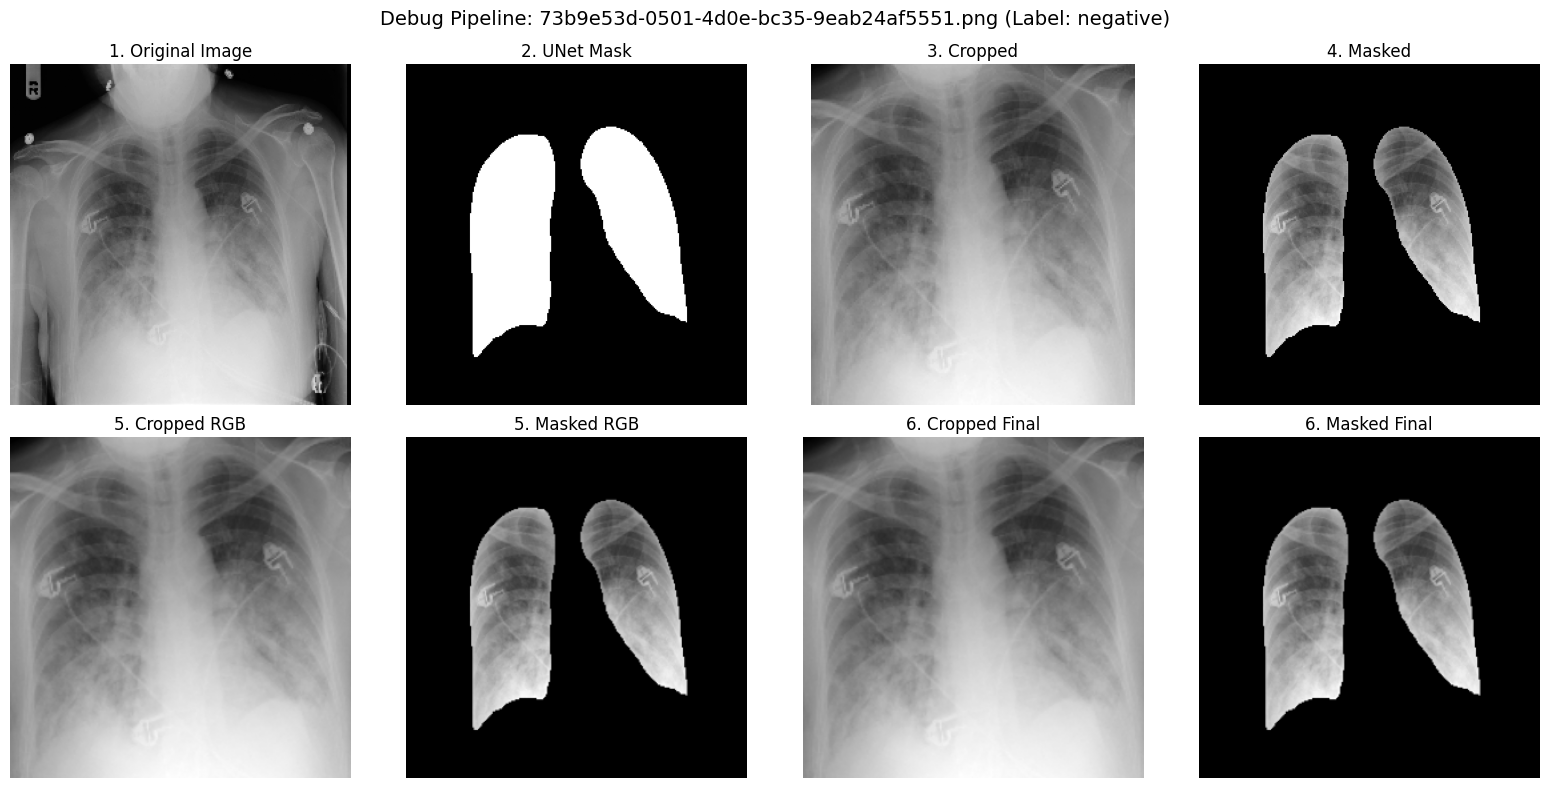

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def debug_generator_pipeline(generator):
    """
    Debug the generator step by step to find where things go wrong
    """
    print("DEBUGGING GENERATOR PIPELINE")
    print("=" * 50)

    # Get a single sample manually
    batch_indices = generator.indices[0:1]  # Just first sample

    for i in batch_indices:
        row = generator.df.iloc[i]
        img_path = os.path.join(generator.img_dir, row['filename'])

        print(f"Processing: {row['filename']}")
        print(f"Label: {row['label']}")

        # Step 1: Load original image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=generator.img_size, color_mode='grayscale')
        img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0

        print(f"\n1. Original image after loading and normalization:")
        print(f"   Shape: {img_arr.shape}")
        print(f"   Pixel range: [{img_arr.min():.3f}, {img_arr.max():.3f}]")
        print(f"   Mean: {img_arr.mean():.3f}")

        # Step 2: UNet prediction
        img_tf = tf.convert_to_tensor(img_arr[np.newaxis, ..., np.newaxis], dtype=tf.float32)
        pred_mask = generator.unet_model.predict(img_tf, verbose=0)
        pred_mask = (pred_mask > 0.5).astype(np.float32).squeeze()

        print(f"\n2. UNet mask prediction:")
        print(f"   Shape: {pred_mask.shape}")
        print(f"   Unique values: {np.unique(pred_mask)}")
        print(f"   Positive pixels: {np.sum(pred_mask > 0)} / {pred_mask.size} ({100*np.sum(pred_mask > 0)/pred_mask.size:.1f}%)")

        if np.sum(pred_mask > 0) == 0:
            print("   ❌ PROBLEM: UNet mask is completely empty!")
            return

        # Step 3: Cropped image
        cropped_img = generator.crop_to_mask_with_padding(img_arr, pred_mask, padding=10)

        print(f"\n3. Cropped image:")
        print(f"   Shape: {cropped_img.shape}")
        print(f"   Pixel range: [{cropped_img.min():.3f}, {cropped_img.max():.3f}]")
        print(f"   Mean: {cropped_img.mean():.3f}")

        # Step 4: Masked image
        masked_img = generator.apply_mask_to_full_image(img_arr, pred_mask)

        print(f"\n4. Masked image:")
        print(f"   Shape: {masked_img.shape}")
        print(f"   Pixel range: [{masked_img.min():.3f}, {masked_img.max():.3f}]")
        print(f"   Mean: {masked_img.mean():.3f}")
        print(f"   Non-zero pixels: {np.sum(masked_img > 0)} / {masked_img.size} ({100*np.sum(masked_img > 0)/masked_img.size:.1f}%)")

        # Step 5: After resize and RGB conversion
        cropped_rgb = generator.resize_and_convert_to_rgb(cropped_img, target_size=(299, 299, 3))
        masked_rgb = generator.resize_and_convert_to_rgb(masked_img, target_size=(299, 299, 3))

        print(f"\n5. After resize and RGB conversion:")
        print(f"   Cropped RGB shape: {cropped_rgb.shape}")
        print(f"   Cropped RGB range: [{cropped_rgb.min():.3f}, {cropped_rgb.max():.3f}]")
        print(f"   Masked RGB shape: {masked_rgb.shape}")
        print(f"   Masked RGB range: [{masked_rgb.min():.3f}, {masked_rgb.max():.3f}]")
        print(f"   Masked RGB non-zero: {np.sum(masked_rgb > 0)} / {masked_rgb.size} ({100*np.sum(masked_rgb > 0)/masked_rgb.size:.1f}%)")

        # Step 6: After Xception preprocessing
        from tensorflow.keras.applications.xception import preprocess_input
        cropped_preprocessed = preprocess_input(cropped_rgb[np.newaxis, ...])[0]
        masked_preprocessed = preprocess_input(masked_rgb[np.newaxis, ...])[0]

        print(f"\n6. After Xception preprocessing:")
        print(f"   Cropped preprocessed range: [{cropped_preprocessed.min():.3f}, {cropped_preprocessed.max():.3f}]")
        print(f"   Cropped preprocessed mean: {cropped_preprocessed.mean():.3f}")
        print(f"   Masked preprocessed range: [{masked_preprocessed.min():.3f}, {masked_preprocessed.max():.3f}]")
        print(f"   Masked preprocessed mean: {masked_preprocessed.mean():.3f}")

        # Visual debugging
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f'Debug Pipeline: {row["filename"]} (Label: {row["label"]})', fontsize=14)

        # Row 1: Original pipeline
        axes[0, 0].imshow(img_arr, cmap='gray')
        axes[0, 0].set_title('1. Original Image')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(pred_mask, cmap='gray')
        axes[0, 1].set_title('2. UNet Mask')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(cropped_img, cmap='gray')
        axes[0, 2].set_title('3. Cropped')
        axes[0, 2].axis('off')

        axes[0, 3].imshow(masked_img, cmap='gray')
        axes[0, 3].set_title('4. Masked')
        axes[0, 3].axis('off')

        # Row 2: After preprocessing
        axes[1, 0].imshow(cropped_rgb[:,:,0], cmap='gray')
        axes[1, 0].set_title('5. Cropped RGB')
        axes[1, 0].axis('off')

        axes[1, 1].imshow(masked_rgb[:,:,0], cmap='gray')
        axes[1, 1].set_title('5. Masked RGB')
        axes[1, 1].axis('off')

        # Show preprocessed (convert back for display)
        cropped_display = (cropped_preprocessed + 1) / 2
        masked_display = (masked_preprocessed + 1) / 2

        axes[1, 2].imshow(cropped_display[:,:,0], cmap='gray')
        axes[1, 2].set_title('6. Cropped Final')
        axes[1, 2].axis('off')

        axes[1, 3].imshow(masked_display[:,:,0], cmap='gray')
        axes[1, 3].set_title('6. Masked Final')
        axes[1, 3].axis('off')

        plt.tight_layout()
        plt.show()

        break  # Only process first sample

def check_unet_model(generator):
    """
    Quick check if UNet model is working
    """
    print("CHECKING UNET MODEL")
    print("=" * 30)

    # Load a sample image
    batch_indices = generator.indices[0:1]
    for i in batch_indices:
        row = generator.df.iloc[i]
        img_path = os.path.join(generator.img_dir, row['filename'])

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=generator.img_size, color_mode='grayscale')
        img_arr = tf.keras.preprocessing.image.img_to_array(img).squeeze(axis=-1) / 255.0

        # Test UNet
        img_tf = tf.convert_to_tensor(img_arr[np.newaxis, ..., np.newaxis], dtype=tf.float32)

        print(f"Input to UNet shape: {img_tf.shape}")
        print(f"Input to UNet range: [{img_tf.numpy().min():.3f}, {img_tf.numpy().max():.3f}]")

        pred_mask = generator.unet_model.predict(img_tf, verbose=1)

        print(f"UNet output shape: {pred_mask.shape}")
        print(f"UNet output range: [{pred_mask.min():.3f}, {pred_mask.max():.3f}]")

        pred_mask_binary = (pred_mask > 0.5).astype(np.float32)
        print(f"After thresholding: {np.sum(pred_mask_binary > 0)} positive pixels")

        if np.sum(pred_mask_binary > 0) == 0:
            print("❌ UNet is not detecting any lung regions!")
            print("This could be because:")
            print("1. UNet model expects different input format")
            print("2. UNet was trained on different image preprocessing")
            print("3. UNet model file is corrupted")
        else:
            print("✓ UNet seems to be working")

        break

# Usage
if __name__ == "__main__":
    # Replace with your generator
    debug_generator_pipeline(train_gen)
    # check_unet_model(your_train_gen)
    pass

In [6]:
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

def build_dual_xception_classifier(num_classes, trainable_cropped=False, trainable_masked=False,
                                 fusion_strategy='concatenate', fusion_layers=[512, 256]):
    """
    Build dual-input Xception classifier with separate branches for cropped and masked images.

    Args:
        num_classes: Number of output classes
        trainable_cropped: Whether cropped branch Xception should be trainable
        trainable_masked: Whether masked branch Xception should be trainable
        fusion_strategy: How to combine features ('concatenate', 'add', 'attention')
        fusion_layers: List of dense layer sizes after fusion

    Returns:
        model: Compiled dual-input model
        cropped_base: Xception base model for cropped images (for weight loading)
        masked_base: Xception base model for masked images
    """
    IMAGE_SIZE = (299, 299, 3)

    # Input layers
    cropped_input = layers.Input(shape=IMAGE_SIZE, name='cropped_input')
    masked_input = layers.Input(shape=IMAGE_SIZE, name='masked_input')

    # Branch 1: Cropped images (anatomical context)
    cropped_base = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE,
        name='cropped_xception'
    )
    cropped_base.trainable = trainable_cropped

    cropped_features = cropped_base(cropped_input, training=trainable_cropped)
    cropped_features = layers.GlobalAveragePooling2D(name='cropped_gap')(cropped_features)
    cropped_features = layers.BatchNormalization(name='cropped_bn1')(cropped_features)
    cropped_features = layers.Dense(512, activation='relu',
                                  kernel_regularizer=l2(1e-4),
                                  name='cropped_dense1')(cropped_features)
    cropped_features = layers.Dropout(0.5, name='cropped_dropout1')(cropped_features)

    # Branch 2: Masked images (pure lung parenchyma)
    masked_base = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE,
        name='masked_xception'
    )
    masked_base.trainable = trainable_masked

    masked_features = masked_base(masked_input, training=trainable_masked)
    masked_features = layers.GlobalAveragePooling2D(name='masked_gap')(masked_features)
    masked_features = layers.BatchNormalization(name='masked_bn1')(masked_features)
    masked_features = layers.Dense(512, activation='relu',
                                 kernel_regularizer=l2(1e-4),
                                 name='masked_dense1')(masked_features)
    masked_features = layers.Dropout(0.5, name='masked_dropout1')(masked_features)

    # Feature fusion
    if fusion_strategy == 'concatenate':
        fused_features = layers.Concatenate(name='feature_fusion')([cropped_features, masked_features])
    elif fusion_strategy == 'add':
        fused_features = layers.Add(name='feature_fusion')([cropped_features, masked_features])
    elif fusion_strategy == 'attention':
        # Simple attention mechanism
        attention_weights = layers.Dense(2, activation='softmax', name='attention_weights')(
            layers.Concatenate()([cropped_features, masked_features])
        )
        cropped_weighted = layers.Multiply()([cropped_features,
                                            layers.Lambda(lambda x: x[:, 0:1])(attention_weights)])
        masked_weighted = layers.Multiply()([masked_features,
                                           layers.Lambda(lambda x: x[:, 1:2])(attention_weights)])
        fused_features = layers.Add(name='feature_fusion')([cropped_weighted, masked_weighted])
    else:
        raise ValueError(f"Unknown fusion strategy: {fusion_strategy}")

    # Classification head
    x = layers.BatchNormalization(name='fusion_bn')(fused_features)

    # Add fusion layers
    for i, layer_size in enumerate(fusion_layers):
        x = layers.Dense(layer_size, activation='relu',
                        kernel_regularizer=l2(1e-4),
                        name=f'fusion_dense_{i+1}')(x)
        dropout_rate = 0.5 if i == 0 else 0.3
        x = layers.Dropout(dropout_rate, name=f'fusion_dropout_{i+1}')(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    # Create model with dictionary inputs to match generator output
    #model = models.Model(inputs={'cropped_input': cropped_input, 'masked_input': masked_input}, outputs=outputs)
    model = models.Model(inputs=[cropped_input, masked_input], outputs=outputs)

    return model, cropped_base, masked_base



In [ ]:
# Test what your generator actually returns
batch = train_gen[0]
print("Batch type:", type(batch))
print("Batch length:", len(batch))
print("Input type:", type(batch[0]))
print("Input structure:", batch[0].keys() if isinstance(batch[0], dict) else "Not a dict")
print("Labels shape:", batch[1].shape)

# Test if model can accept this format
try:
    prediction = model.predict(batch[0])
    print("✓ Model accepts generator output format")
except Exception as e:
    print(f"❌ Model prediction failed: {e}")

<class 'numpy.ndarray'>
Batch type: <class 'tuple'>
Batch length: 2
Input type: <class 'list'>
Input structure: Not a dict
Labels shape: (32, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
✓ Model accepts generator output format


In [ ]:
num_classes=2
model, cropped_base, masked_base=build_dual_xception_classifier(num_classes, trainable_cropped=False, trainable_masked=False,
                                 fusion_strategy='concatenate', fusion_layers=[512, 256])
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cropped_input       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_input        │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropped_xception    │ (None, 10, 10,    │ 20,861,480 │ cropped_input[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_xception     │ (None, 10, 10,    │ 20,861,480 │ masked_input[0][… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropped_gap         │ (None, 2048)      │          0 │ cropped_xception… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_gap          │ (None, 2048)      │          0 │ masked_xception[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropped_bn1         │ (None, 2048)      │      8,192 │ cropped_gap[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_bn1          │ (None, 2048)      │      8,192 │ masked_gap[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropped_dense1      │ (None, 512)       │  1,049,088 │ cropped_bn1[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_dense1       │ (None, 512)       │  1,049,088 │ masked_bn1[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropped_dropout1    │ (None, 512)       │          0 │ cropped_dense1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_dropout1     │ (None, 512)       │          0 │ masked_dense1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_fusion      │ (None, 1024)      │          0 │ cropped_dropout1… │
│ (Concatenate)       │                   │            │ masked_dropout1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_bn           │ (None, 1024)      │      4,096 │ feature_fusion[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense_1      │ (None, 512)       │    524,800 │ fusion_bn[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout_1    │ (None, 512)       │          0 │ fusion_dense_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense_2      │ (None, 256)       │    131,328 │ fusion_dropout_1

 Total params: 44,498,258 (169.75 MB)

 Trainable params: 2,765,058 (10.55 MB)

 Non-trainable params: 41,733,200 (159.20 MB)

=== PHASE 1: Training with frozen base model ===
Initial learning rate: 0.0001
Epochs: 7
Training samples per epoch: 8544
Validation samples: 8480

Model Summary:
Total parameters: 44,498,258
Trainable parameters: 2,765,058
Non-trainable parameters: 41,733,200

Class distribution:
Training: label
negative    4267
positive    4264
Name: count, dtype: int64
Validation: label
positive    4241
negative    4232
Name: count, dtype: int64

Starting Phase 1 Training...
models dir:  /content/drive/MyDrive/Covid-19_Presence/models
Epoch 1/7
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8090 - loss: 0.7185 - precision: 0.8090 - recall: 0.8090
Epoch 1: val_loss improved from inf to 0.62021, saving model to /content/drive/MyDrive/Covid-19_Presence/models/best_covid_dual_phase1.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 1024s 4s/step - accuracy: 0.8090 - loss: 0.7184 - precision: 0.8090 - recall: 0.8090 - val_accuracy: 0.8437 - val_loss: 0.6202 - val_precision: 0.8437 - val_recall: 0.8437 - learning

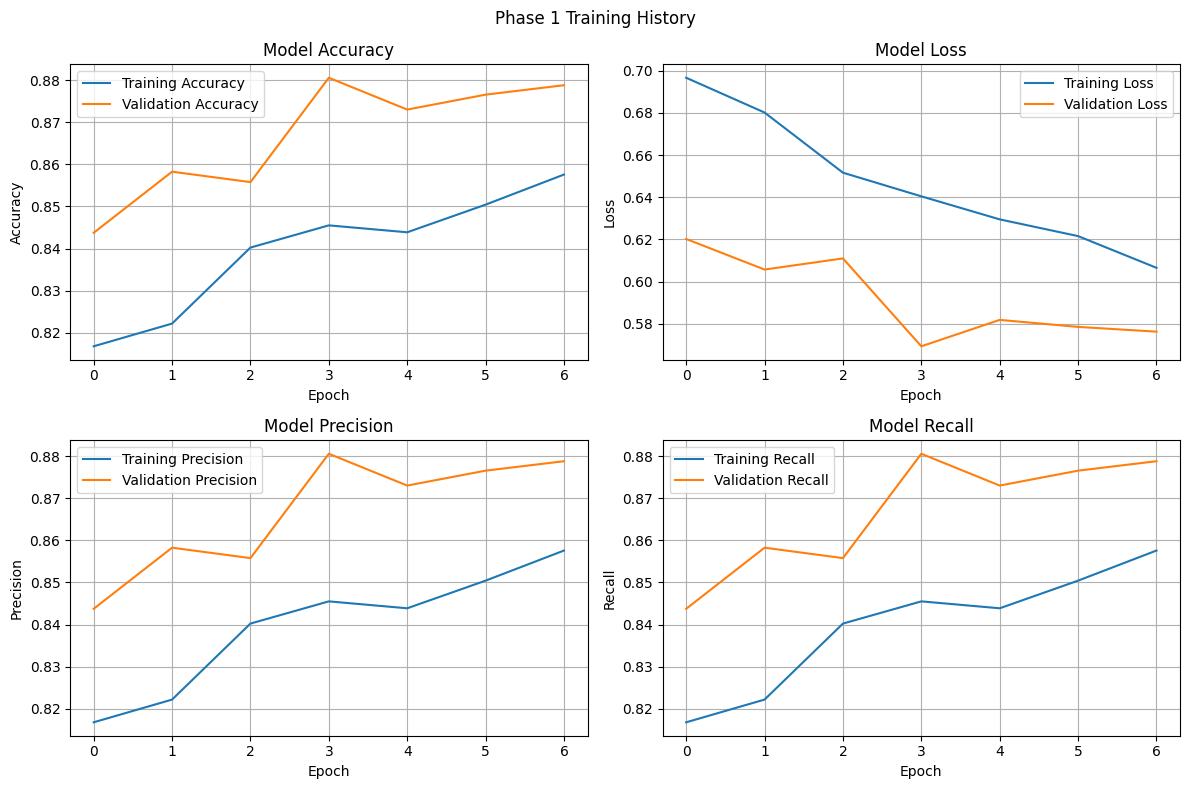


Ready for Phase 2! Load the best model from: /content/drive/MyDrive/Covid-19_Presence/models/best_covid_dual_phase1.keras
Next steps:
1. Load the best Phase 1 model
2. Unfreeze base model layers
3. Recompile with lower learning rate
4. Train for more epochs


In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import runtime


# Phase 1 Training Parameters
epochs = 7  # Increased from 5 - you might need more for head to converge
initial_lr = 1e-4

print("=== PHASE 1: Training with frozen base model ===")
print(f"Initial learning rate: {initial_lr}")
print(f"Epochs: {epochs}")
print(f"Training samples per epoch: {len(train_gen) * train_gen.batch_size}")
print(f"Validation samples: {len(val_gen) * val_gen.batch_size}")


best_model_path = os.path.join(models_dir, 'best_covid_dual_phase1.keras')
final_model_path = os.path.join(models_dir, 'final_covid_dual_phase1.keras')

existing_model=os.path.join(models_dir,'best_covid_dual_phase1.keras')
model.load_weights(existing_model)
# Create comprehensive callbacks
callbacks = [
    # Save best model based on validation loss
    ModelCheckpoint(
        filepath=best_model_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1,
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=3,  # Stop if no improvement for 3 epochs
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half
        patience=2,  # Wait 2 epochs before reducing
        min_lr=1e-7,  # Don't go below this LR
        verbose=1
    )
]

# Compile model for Phase 1
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model info
print(f"\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
trainable_count = sum([tf.reduce_prod(var.shape) for var in model.trainable_variables])
print(f"Trainable parameters: {trainable_count:,}")
non_trainable_count = model.count_params() - trainable_count
print(f"Non-trainable parameters: {non_trainable_count:,}")

# Check class distribution
print(f"\nClass distribution:")
print(f"Training: {train_gen.get_class_distribution()}")
print(f"Validation: {val_gen.get_class_distribution()}")

# Start training
print(f"\n{'='*50}")
print("Starting Phase 1 Training...")
print(f"{'='*50}")
print('models dir: ', models_dir)
try:
    history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,                 # Add this   # Add this
)
    # Save final model (regardless of whether it's the best)
    model.save(final_model_path)
    print(f"Final model saved to: {final_model_path}")

    # Print training results
    print(f"\n{'='*50}")
    print("Phase 1 Training Complete!")
    print(f"{'='*50}")

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss) + 1
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")

except KeyboardInterrupt:
    print("\nTraining interrupted by user")
    model.save(os.path.join(models_dir, 'interrupted_model_phase1.keras'))

except Exception as e:
    print(f"\nTraining failed with error: {str(e)}")
    model.save(os.path.join(models_dir, 'error_model_phase1.keras'))
    raise

# Plot training history
def plot_training_history(history, phase="Phase 1"):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'{phase} Training History')

    # Accuracy
    axes[0,0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0,0].set_title('Model Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Loss
    axes[0,1].plot(history.history['loss'], label='Training Loss')
    axes[0,1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0,1].set_title('Model Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Precision
    if 'precision' in history.history:
        axes[1,0].plot(history.history['precision'], label='Training Precision')
        axes[1,0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1,0].set_title('Model Precision')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].legend()
        axes[1,0].grid(True)

    # Recall
    if 'recall' in history.history:
        axes[1,1].plot(history.history['recall'], label='Training Recall')
        axes[1,1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1,1].set_title('Model Recall')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Recall')
        axes[1,1].legend()
        axes[1,1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, f'{phase.lower().replace(" ", "_")}_history.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

# Plot the results
if 'history' in locals():
    plot_training_history(history, "Phase 1")

print(f"\nReady for Phase 2! Load the best model from: {best_model_path}")
print("Next steps:")
print("1. Load the best Phase 1 model")
print("2. Unfreeze base model layers")
print("3. Recompile with lower learning rate")
print("4. Train for more epochs")
#runtime.unassign()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


only_unfreeze_some=True
# Phase 2: Build model with trainable=True
print("=== PHASE 2: Fine-tuning ===")
model, cropped_base, masked_base = build_dual_xception_classifier(num_classes, trainable_cropped=True, trainable_masked=True,
                                 fusion_strategy='concatenate', fusion_layers=[512, 256])

# Load Phase 1 weights
phase1_weights = os.path.join(models_dir, 'best_covid_dual_phase1.keras')
phase2_path=os.path.join(models_dir, 'best_covid_dual_phase2.keras')
model.load_weights(phase1_weights)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in cropped_base.layers[:-5]:
      layer.trainable = False
  for layer in masked_base.layers[:-5]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

# Compile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Simple callbacks
callbacks = [
    ModelCheckpoint(phase2_path,
                   save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Train Phase 2
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)

print("Phase 2 complete!")

=== PHASE 2: Fine-tuning ===
Trainable params: 9,098,498


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 1211s 4s/step - accuracy: 0.8276 - loss: 0.6614 - val_accuracy: 0.8593 - val_loss: 0.5969
Epoch 2/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 948s 4s/step - accuracy: 0.8366 - loss: 0.6579 - val_accuracy: 0.8652 - val_loss: 0.5884
Epoch 3/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 952s 4s/step - accuracy: 0.8372 - loss: 0.6354 - val_accuracy: 0.8705 - val_loss: 0.5839
Epoch 4/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 954s 4s/step - accuracy: 0.8379 - loss: 0.6426 - val_accuracy: 0.8736 - val_loss: 0.5809
Epoch 5/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 946s 4s/step - accuracy: 0.8485 - loss: 0.6231 - val_accuracy: 0.8753 - val_loss: 0.5750
Epoch 6/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 952s 4s/step - accuracy: 0.8485 - loss: 0.6284 - val_accuracy: 0.8794 - val_loss: 0.5712
Epoch 7/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 958s 4s/step - accuracy: 0.8640 - loss: 0.5953 - val_accuracy: 0.8712 - val_loss: 0.5800
Epoch 8/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 943s 4s/step - accuracy: 0.8590 - loss: 0.6090 - val_acc

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


only_unfreeze_some=True
# Phase 2: Build model with trainable=True
print("=== PHASE 2B: keep going with phase 2 ===")
model, cropped_base, masked_base = build_dual_xception_classifier(num_classes, trainable_cropped=True, trainable_masked=True,
                                 fusion_strategy='concatenate', fusion_layers=[512, 256])

# Load Phase 2 weights
phase1_weights = os.path.join(models_dir, 'best_covid_dual_phase1.keras')
phase2_path=os.path.join(models_dir, 'best_covid_dual_phase2.keras')
model.load_weights(phase2_path)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in cropped_base.layers[:-5]:
      layer.trainable = False
  for layer in masked_base.layers[:-5]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

# Compile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Simple callbacks
callbacks = [
    ModelCheckpoint(phase2_path,
                   save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Train Phase 2
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)

print("Phase 2B complete!")

=== PHASE 3: keep going with phase 2 ===
Trainable params: 9,098,498
Epoch 1/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 1039s 4s/step - accuracy: 0.8769 - loss: 0.5730 - val_accuracy: 0.8938 - val_loss: 0.5431
Epoch 2/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 944s 4s/step - accuracy: 0.8785 - loss: 0.5618 - val_accuracy: 0.8957 - val_loss: 0.5403
Epoch 3/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 940s 4s/step - accuracy: 0.8692 - loss: 0.5719 - val_accuracy: 0.8996 - val_loss: 0.5310
Epoch 4/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 942s 4s/step - accuracy: 0.8760 - loss: 0.5685 - val_accuracy: 0.8958 - val_loss: 0.5395
Epoch 5/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 943s 4s/step - accuracy: 0.8825 - loss: 0.5547 - val_accuracy: 0.8991 - val_loss: 0.5338
Epoch 6/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 937s 4s/step - accuracy: 0.8875 - loss: 0.5519 - val_accuracy: 0.8956 - val_loss: 0.5401
Epoch 7/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 939s 4s/step - accuracy: 0.8888 - loss: 0.5510 - val_accuracy: 0.8992 - val_loss: 0.5350
Epoch 8/12
267/267 ━━━━━━━━

In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

class CustomValAccCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, initial_val_acc=0.0):
        super().__init__()
        self.filepath = filepath
        self.best_val_acc = initial_val_acc

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None:
            if current_val_acc > self.best_val_acc:
                self.best_val_acc = current_val_acc
                self.model.save(self.filepath)
                print(f"\nEpoch {epoch+1}: val_accuracy improved to {current_val_acc:.4f}, saving model.")
            else:
                print(f"\nEpoch {epoch+1}: val_accuracy did not improve from {self.best_val_acc:.4f}")

# Load Phase 2 weights
phase2_path=os.path.join(models_dir, 'best_covid_dual_phase2.keras')
model.load_weights(phase2_path)

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in cropped_base.layers[:-5]:
      layer.trainable = False
  for layer in masked_base.layers[:-5]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

# Compile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Usage:
initial_val_acc = 0.9020  # Your current best val_accuracy
checkpoint_path = phase2_path

custom_checkpoint = CustomValAccCheckpoint(filepath=checkpoint_path, initial_val_acc=initial_val_acc)

# Replace or add to your callbacks list:
callbacks = [
    custom_checkpoint,
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
       # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half
        patience=2,  # Wait 2 epochs before reducing
        min_lr=1e-7,  # Don't go below this LR
        verbose=1
    )
]

# Then train:
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)


Trainable params: 9,098,498
Epoch 1/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8832 - loss: 0.5554
Epoch 1: val_accuracy improved to 0.9055, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 1048s 4s/step - accuracy: 0.8832 - loss: 0.5554 - val_accuracy: 0.9055 - val_loss: 0.5231 - learning_rate: 1.0000e-05
Epoch 2/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8833 - loss: 0.5429
Epoch 2: val_accuracy did not improve from 0.9055
267/267 ━━━━━━━━━━━━━━━━━━━━ 950s 4s/step - accuracy: 0.8833 - loss: 0.5429 - val_accuracy: 0.9024 - val_loss: 0.5260 - learning_rate: 1.0000e-05
Epoch 3/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8928 - loss: 0.5404
Epoch 3: val_accuracy did not improve from 0.9055

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
267/267 ━━━━━━━━━━━━━━━━━━━━ 952s 4s/step - accuracy: 0.8928 - loss: 0.5404 - val_accuracy: 0.9030 - val_loss: 0.5249 - learning_rate: 1.0000e-05
Epoch 4/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

class CustomValAccCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, initial_val_acc=0.0):
        super().__init__()
        self.filepath = filepath
        self.best_val_acc = initial_val_acc

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None:
            if current_val_acc > self.best_val_acc:
                self.best_val_acc = current_val_acc
                self.model.save(self.filepath)
                print(f"\nEpoch {epoch+1}: val_accuracy improved to {current_val_acc:.4f}, saving model.")
            else:
                print(f"\nEpoch {epoch+1}: val_accuracy did not improve from {self.best_val_acc:.4f}")

In [17]:
print("=== PHASE 3: Unfreeze 5 more layers ===")
num_classes=2
model, cropped_base, masked_base = build_dual_xception_classifier(num_classes, trainable_cropped=True, trainable_masked=True,
                                 fusion_strategy='concatenate', fusion_layers=[512, 256])
# Load Phase 2 weights
phase2_path=os.path.join(models_dir, 'best_covid_dual_phase2.keras')
model.load_weights(phase2_path)

only_unfreeze_some=True

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in cropped_base.layers[:-10]:
      layer.trainable = False
  for layer in masked_base.layers[:-10]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

# Compile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Usage:
initial_val_acc = 0.9226 #0.9055  # Your current best val_accuracy
checkpoint_path = phase2_path

custom_checkpoint = CustomValAccCheckpoint(filepath=checkpoint_path, initial_val_acc=initial_val_acc)

# Replace or add to your callbacks list:
callbacks = [
    custom_checkpoint,
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
       ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.9,  # Reduce LR by half
        patience=3,  # Wait 3 epochs before reducing
        min_lr=1e-7,  # Don't go below this LR
        verbose=1
    )

]

# Then train:
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)
print("Phase 3 complete!")

=== PHASE 3: Unfreeze 5 more layers ===
Trainable params: 13,757,698


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9105 - loss: 0.4955
Epoch 1: val_accuracy did not improve from 0.9226
267/267 ━━━━━━━━━━━━━━━━━━━━ 1185s 4s/step - accuracy: 0.9105 - loss: 0.4955 - val_accuracy: 0.9220 - val_loss: 0.4891 - learning_rate: 1.0000e-05
Epoch 2/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9205 - loss: 0.4782
Epoch 2: val_accuracy did not improve from 0.9226
267/267 ━━━━━━━━━━━━━━━━━━━━ 910s 3s/step - accuracy: 0.9205 - loss: 0.4782 - val_accuracy: 0.9221 - val_loss: 0.4842 - learning_rate: 1.0000e-05
Epoch 3/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9123 - loss: 0.4883
Epoch 3: val_accuracy did not improve from 0.9226
267/267 ━━━━━━━━━━━━━━━━━━━━ 905s 3s/step - accuracy: 0.9123 - loss: 0.4883 - val_accuracy: 0.9149 - val_loss: 0.5056 - learning_rate: 1.0000e-05
Epoch 4/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9150 - loss: 0.4828
Epoch 4: val_accuracy did not improve from 0.9226
267/267 ━━━━━━━━━━━━━

In [18]:
print("=== PHASE 4: Unfreeze 5 more layers ===")
num_classes=2
model, cropped_base, masked_base = build_dual_xception_classifier(num_classes, trainable_cropped=True, trainable_masked=True,
                                 fusion_strategy='concatenate', fusion_layers=[512, 256])
# Load Phase 2 weights
phase2_path=os.path.join(models_dir, 'best_covid_dual_phase2.keras')
model.load_weights(phase2_path)
phase3_path=os.path.join(models_dir, 'best_covid_dual_phase3.keras')
only_unfreeze_some=True

if only_unfreeze_some:
  # Optionally freeze early layers (safer)
  for layer in cropped_base.layers[:-15]:
      layer.trainable = False
  for layer in masked_base.layers[:-15]:
      layer.trainable = False

print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

# Compile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Usage:
initial_val_acc = 0.9323 #0.9055  # Your current best val_accuracy
checkpoint_path = phase3_path

custom_checkpoint = CustomValAccCheckpoint(filepath=checkpoint_path, initial_val_acc=initial_val_acc)

# Replace or add to your callbacks list:
callbacks = [
    custom_checkpoint,
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
       ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.9,  # Reduce LR by half
        patience=3,  # Wait 3 epochs before reducing
        min_lr=1e-7,  # Don't go below this LR
        verbose=1
    )

]

# Then train:
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)
print("Phase 4 complete!")

=== PHASE 4: Unfreeze 5 more layers ===
Trainable params: 16,341,826
Epoch 1/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9013 - loss: 0.5101
Epoch 1: val_accuracy did not improve from 0.9323
267/267 ━━━━━━━━━━━━━━━━━━━━ 1032s 4s/step - accuracy: 0.9013 - loss: 0.5101 - val_accuracy: 0.9280 - val_loss: 0.4787 - learning_rate: 9.0000e-06
Epoch 2/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9079 - loss: 0.4864
Epoch 2: val_accuracy did not improve from 0.9323
267/267 ━━━━━━━━━━━━━━━━━━━━ 919s 3s/step - accuracy: 0.9079 - loss: 0.4864 - val_accuracy: 0.9266 - val_loss: 0.4742 - learning_rate: 9.0000e-06
Epoch 3/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9125 - loss: 0.4834
Epoch 3: val_accuracy did not improve from 0.9323
267/267 ━━━━━━━━━━━━━━━━━━━━ 922s 3s/step - accuracy: 0.9125 - loss: 0.4834 - val_accuracy: 0.9281 - val_loss: 0.4697 - learning_rate: 9.0000e-06
Epoch 4/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9132 - loss: 0.4744
Ep

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


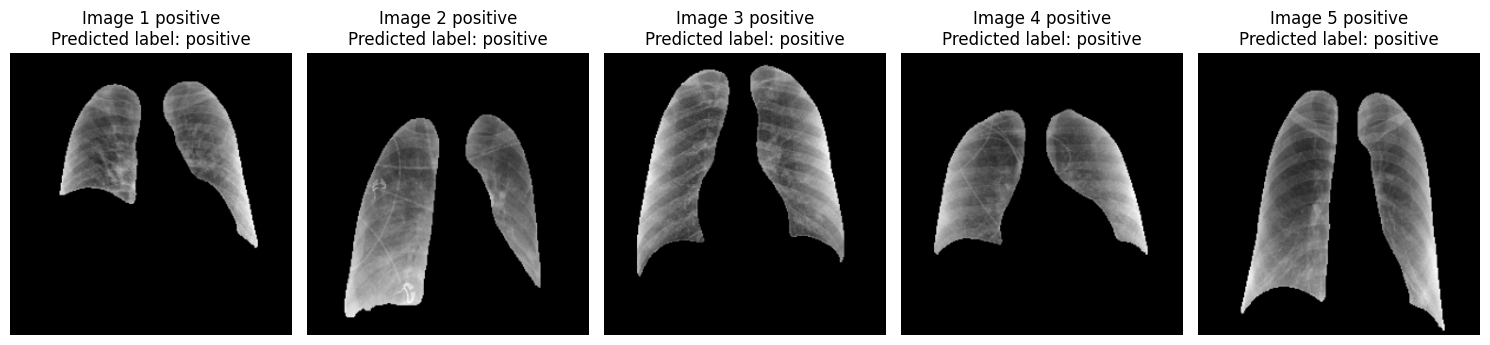

In [30]:
num_classes=2
model, cropped_base, masked_base = build_dual_xception_classifier(num_classes, trainable_cropped=True, trainable_masked=True,
                                 fusion_strategy='concatenate', fusion_layers=[512, 256])


phase2_path=os.path.join(models_dir, 'best_covid_dual_phase2.keras')
model.load_weights(phase2_path)


# Assuming you already have the first batch from your data generator
(cropped_images, masked_images),labels = test_gen[0]

# Take the first 5 images from the batch
first_five_masked_images = masked_images[:5]
first_five_cropped_images = cropped_images[:5]
first_five_labels=labels[:5]
preds=model.predict((first_five_cropped_images,first_five_masked_images))
preds=np.argmax(preds, axis=1)
preds=[test_gen.label_encoder.classes_[p] for p in preds]
# first_five_labels is shape (batch_size, num_classes), e.g., one-hot vectors

# Convert one-hot vectors to class indices (integers)
label_indices = np.argmax(first_five_labels, axis=1)

# Now inverse transform using integer indices
decoded_labels = train_gen.label_encoder.inverse_transform(label_indices)


plt.figure(figsize=(15, 6))
for i, img in enumerate(first_five_masked_images):
    # img is a NumPy array; no need for .numpy()
    grayscale_img = img.mean(axis=-1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title(f'Image {i+1} {decoded_labels[i]}\nPredicted label: {preds[i]}')
    plt.axis('off')


plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pandas as pd

def evaluate_test_set(model, test_gen, verbose=True):
    """
    Evaluate model on test set and calculate comprehensive metrics

    Args:
        model: Trained Keras model
        test_gen: Test data generator
        verbose: Whether to print detailed results

    Returns:
        dict: Dictionary containing all metrics
    """

    print("Evaluating model on test set...")
    print(f"Test set size: {len(test_gen)} batches")

    # Collect all predictions and true labels
    all_predictions = []
    all_true_labels = []
    all_probabilities = []

    # Iterate through test generator
    for batch_idx in range(len(test_gen)):
        if verbose and batch_idx % 10 == 0:
            print(f"Processing batch {batch_idx + 1}/{len(test_gen)}")

        # Get batch data
        (x_cropped, x_masked), y_true = test_gen[batch_idx]

        if len(x_cropped) == 0:  # Skip empty batches
            continue

        # Get model predictions
        y_pred_probs = model.predict([x_cropped, x_masked], verbose=0)

        # Convert probabilities to class predictions
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        y_true_classes = np.argmax(y_true, axis=1)

        # Store results
        all_predictions.extend(y_pred_classes)
        all_true_labels.extend(y_true_classes)
        all_probabilities.extend(y_pred_probs)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)
    all_probabilities = np.array(all_probabilities)

    print(f"\nTotal samples evaluated: {len(all_predictions)}")

    # Calculate metrics
    metrics = {}

    # Overall accuracy
    accuracy = np.mean(all_predictions == all_true_labels)
    metrics['accuracy'] = accuracy

    # F1 scores
    f1_macro = f1_score(all_true_labels, all_predictions, average='macro')
    f1_micro = f1_score(all_true_labels, all_predictions, average='micro')
    f1_weighted = f1_score(all_true_labels, all_predictions, average='weighted')

    metrics['f1_macro'] = f1_macro
    metrics['f1_micro'] = f1_micro
    metrics['f1_weighted'] = f1_weighted

    # Per-class F1 scores
    f1_per_class = f1_score(all_true_labels, all_predictions, average=None)

    # Get class names from label encoder
    class_names = test_gen.label_encoder.classes_

    for i, class_name in enumerate(class_names):
        metrics[f'f1_{class_name}'] = f1_per_class[i]

    # Precision and Recall
    precision_macro = precision_score(all_true_labels, all_predictions, average='macro')
    recall_macro = recall_score(all_true_labels, all_predictions, average='macro')

    metrics['precision_macro'] = precision_macro
    metrics['recall_macro'] = recall_macro

    # Per-class precision and recall
    precision_per_class = precision_score(all_true_labels, all_predictions, average=None)
    recall_per_class = recall_score(all_true_labels, all_predictions, average=None)

    for i, class_name in enumerate(class_names):
        metrics[f'precision_{class_name}'] = precision_per_class[i]
        metrics[f'recall_{class_name}'] = recall_per_class[i]

    if verbose:
        print("\n" + "="*50)
        print("TEST SET EVALUATION RESULTS")
        print("="*50)

        print(f"\nOverall Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (Macro): {f1_macro:.4f}")
        print(f"F1 Score (Micro): {f1_micro:.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"Precision (Macro): {precision_macro:.4f}")
        print(f"Recall (Macro): {recall_macro:.4f}")

        print(f"\nPer-Class Metrics:")
        print("-" * 30)
        for i, class_name in enumerate(class_names):
            print(f"{class_name}:")
            print(f"  F1:        {f1_per_class[i]:.4f}")
            print(f"  Precision: {precision_per_class[i]:.4f}")
            print(f"  Recall:    {recall_per_class[i]:.4f}")

        print(f"\nConfusion Matrix:")
        print("-" * 20)
        cm = confusion_matrix(all_true_labels, all_predictions)

        # Create a formatted confusion matrix
        cm_df = pd.DataFrame(cm,
                           index=[f'True {class_names[i]}' for i in range(len(class_names))],
                           columns=[f'Pred {class_names[i]}' for i in range(len(class_names))])
        print(cm_df)

        print(f"\nDetailed Classification Report:")
        print("-" * 35)
        print(classification_report(all_true_labels, all_predictions,
                                  target_names=class_names, digits=4))

    return metrics, all_probabilities, all_predictions, all_true_labels

def analyze_misclassifications(test_gen, all_probabilities, all_predictions, all_true_labels,
                             top_n=10, verbose=True):
    """
    Analyze the most confident misclassifications

    Args:
        test_gen: Test data generator
        all_probabilities: Model probability outputs
        all_predictions: Predicted classes
        all_true_labels: True classes
        top_n: Number of top misclassifications to show
    """

    # Find misclassified samples
    misclassified_mask = all_predictions != all_true_labels

    if not np.any(misclassified_mask):
        print("No misclassifications found!")
        return

    # Get confidence scores for predictions
    prediction_confidence = np.max(all_probabilities, axis=1)

    # Get misclassified samples with their confidence
    misclassified_indices = np.where(misclassified_mask)[0]
    misclassified_confidences = prediction_confidence[misclassified_mask]
    misclassified_predictions = all_predictions[misclassified_mask]
    misclassified_true_labels = all_true_labels[misclassified_mask]

    # Sort by confidence (most confident mistakes first)
    sorted_indices = np.argsort(misclassified_confidences)[::-1]

    class_names = test_gen.label_encoder.classes_

    if verbose:
        print(f"\nMISCLASSIFICATION ANALYSIS")
        print("=" * 40)
        print(f"Total misclassifications: {len(misclassified_indices)}")
        print(f"Misclassification rate: {len(misclassified_indices)/len(all_predictions):.4f}")

        print(f"\nTop {min(top_n, len(misclassified_indices))} Most Confident Mistakes:")
        print("-" * 60)

        for i in range(min(top_n, len(sorted_indices))):
            idx = sorted_indices[i]
            original_idx = misclassified_indices[idx]

            true_class = class_names[misclassified_true_labels[idx]]
            pred_class = class_names[misclassified_predictions[idx]]
            confidence = misclassified_confidences[idx]

            print(f"{i+1:2d}. Sample {original_idx:4d}: "
                  f"True={true_class:8s} | Pred={pred_class:8s} | "
                  f"Confidence={confidence:.4f}")

# Main evaluation function
def run_complete_test_evaluation(model, test_gen):
    """
    Run complete test evaluation with all metrics and analysis
    """

    # Main evaluation
    metrics, probabilities, predictions, true_labels = evaluate_test_set(model, test_gen, verbose=True)

    # Misclassification analysis
    analyze_misclassifications(test_gen, probabilities, predictions, true_labels,
                             top_n=10, verbose=True)

    # Class distribution analysis
    print(f"\nCLASS DISTRIBUTION ANALYSIS")
    print("=" * 30)

    class_names = test_gen.label_encoder.classes_

    print("Test set distribution:")
    for i, class_name in enumerate(class_names):
        count = np.sum(true_labels == i)
        percentage = count / len(true_labels) * 100
        print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

    print("\nPredicted distribution:")
    for i, class_name in enumerate(class_names):
        count = np.sum(predictions == i)
        percentage = count / len(predictions) * 100
        print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

    return metrics

# Usage example:
if __name__ == "__main__":
    # Run the evaluation
    print("Starting test set evaluation...")
    test_metrics = run_complete_test_evaluation(model, val_gen)

    # Print final summary
    print(f"\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Macro): {test_metrics['f1_macro']:.4f}")
    print(f"Test F1 (Weighted): {test_metrics['f1_weighted']:.4f}")

    # Save results to file
    results_df = pd.DataFrame([test_metrics])
    results_df.to_csv('test_evaluation_results.csv', index=False)
    print(f"\nResults saved to 'test_evaluation_results.csv'")

Starting test set evaluation...
Evaluating model on test set...
Test set size: 530 batches
Processing batch 1/530
Processing batch 11/530
Processing batch 21/530
Processing batch 31/530
Processing batch 41/530
Processing batch 51/530
Processing batch 61/530
Processing batch 71/530
Processing batch 81/530
Processing batch 91/530
Processing batch 101/530
Processing batch 111/530
Processing batch 121/530
Processing batch 131/530
Processing batch 141/530
Processing batch 151/530
Processing batch 161/530
Processing batch 171/530
Processing batch 181/530
Processing batch 191/530
Processing batch 201/530
Processing batch 211/530
Processing batch 221/530
Processing batch 231/530
Processing batch 241/530
Processing batch 251/530
Processing batch 261/530
Processing batch 271/530
Processing batch 281/530
Processing batch 291/530
Processing batch 301/530
Processing batch 311/530
Processing batch 321/530
Processing batch 331/530
Processing batch 341/530
Processing batch 351/530
Processing batch 361

In [20]:
# Compare image statistics between val and test
(val_x1, val_x2), val_y = val_gen[0]
(test_x1, test_x2), test_y = test_gen[0]

print("Validation image stats:")
print(f"Input1: min={val_x1.min():.3f}, max={val_x1.max():.3f}, mean={val_x1.mean():.3f}")
print(f"Input2: min={val_x2.min():.3f}, max={val_x2.max():.3f}, mean={val_x2.mean():.3f}")

print("Test image stats:")
print(f"Input1: min={test_x1.min():.3f}, max={test_x1.max():.3f}, mean={test_x1.mean():.3f}")
print(f"Input2: min={test_x2.min():.3f}, max={test_x2.max():.3f}, mean={test_x2.mean():.3f}")

Validation image stats:
Input1: min=-1.000, max=1.000, mean=-0.157
Input2: min=-1.000, max=0.731, mean=-0.865
Test image stats:
Input1: min=-1.000, max=1.000, mean=-0.013
Input2: min=-1.000, max=0.619, mean=-0.815


In [24]:
# Compare U-Net mask predictions between val and test
(val_x1, val_x2), _ = val_gen[0]
(test_x1, test_x2), _ = test_gen[0]

# Get original images before masking (from your generator)
val_original = val_x1[0] * 255  # Convert back from preprocessed
test_original = test_x1[0] * 255
unet_model = tf.keras.models.load_model(os.path.join(models_dir, 'generator_gan_model_run2.keras'))


# Generate masks
val_masks = unet_model.predict(val_original[..., np.newaxis])
test_masks = unet_model.predict(test_original[..., np.newaxis])

print("Mask statistics:")
print(f"Val mask coverage: {(val_masks > 0.5).mean():.3f}")
print(f"Test mask coverage: {(test_masks > 0.5).mean():.3f}")

ValueError: Input 0 of layer "U-Net" is incompatible with the layer: expected shape=(None, 256, 256, 1), found shape=(32, 299, 3)

In [26]:
# Get raw images before Xception preprocessing
(val_x1, val_x2), _ = val_gen[0]
(test_x1, test_x2), _ = test_gen[0]

# The generator already applied U-Net during data loading, but let's check
# the original pipeline. We need to get the raw 256x256 grayscale images
# before they were resized to 299x299 and converted to RGB

# Let's instead examine the masks that were already generated by your generator
# by looking at the difference between input1 (cropped) and input2 (masked)

print("Checking mask effectiveness:")

# Sample a few images
for i in range(5):
    val_cropped = val_x1[i]
    val_masked = val_x2[i]
    test_cropped = test_x1[i]
    test_masked = test_x2[i]

    # Convert to grayscale for comparison
    val_cropped_gray = val_cropped.mean(axis=-1)
    val_masked_gray = val_masked.mean(axis=-1)
    test_cropped_gray = test_cropped.mean(axis=-1)
    test_masked_gray = test_masked.mean(axis=-1)

    # Check how much of the image is "masked out" (set to background)
    val_mask_coverage = (val_masked_gray > val_masked_gray.min()).sum() / val_masked_gray.size
    test_mask_coverage = (test_masked_gray > test_masked_gray.min()).sum() / test_masked_gray.size

    print(f"Sample {i}:")
    print(f"  Val mask coverage: {val_mask_coverage:.3f}")
    print(f"  Test mask coverage: {test_mask_coverage:.3f}")

    # Check if cropped regions are very different sizes
    val_nonzero = (val_cropped_gray > val_cropped_gray.min()).sum()
    test_nonzero = (test_cropped_gray > test_cropped_gray.min()).sum()

    print(f"  Val cropped region size: {val_nonzero}")
    print(f"  Test cropped region size: {test_nonzero}")

Checking mask effectiveness:
Sample 0:
  Val mask coverage: 0.249
  Test mask coverage: 0.179
  Val cropped region size: 89380
  Test cropped region size: 89400
Sample 1:
  Val mask coverage: 0.178
  Test mask coverage: 0.249
  Val cropped region size: 89400
  Test cropped region size: 89400
Sample 2:
  Val mask coverage: 0.292
  Test mask coverage: 0.269
  Val cropped region size: 89106
  Test cropped region size: 89337
Sample 3:
  Val mask coverage: 0.262
  Test mask coverage: 0.201
  Val cropped region size: 89400
  Test cropped region size: 89400
Sample 4:
  Val mask coverage: 0.199
  Test mask coverage: 0.307
  Val cropped region size: 89400
  Test cropped region size: 89399


In [28]:
# Verify you're using the right model
# Compile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Current model summary:")
print(f"Total params: {model.count_params():,}")
print(f"Trainable params: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

# Test if the model gives reasonable predictions on validation
val_acc = model.evaluate(val_gen, verbose=0)[1]
print(f"Quick validation accuracy check: {val_acc:.4f}")

Current model summary:
Total params: 44,498,258
Trainable params: 44,378,962


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [32]:
# Check if the model is outputting extreme probabilities on test data
(test_x1, test_x2), test_y = test_gen[699]
raw_preds = model.predict([test_x1, test_x2])

pos_probs = raw_preds[:, 1]  # Positive class probabilities
print(f"Test set - Positive probability stats:")
print(f"  Mean: {pos_probs.mean():.3f}")
print(f"  Std: {pos_probs.std():.3f}")
print(f"  Min: {pos_probs.min():.3f}")
print(f"  Max: {pos_probs.max():.3f}")
print(f"  % predictions > 0.5: {(pos_probs > 0.5).mean():.3f}")
print(f"  % predictions > 0.9: {(pos_probs > 0.9).mean():.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Test set - Positive probability stats:
  Mean: 0.829
  Std: 0.100
  Min: 0.626
  Max: 0.932
  % predictions > 0.5: 1.000
  % predictions > 0.9: 0.125


In [39]:
train_data=train_gen.df
print('*******Training**********')
positives=train_data[train_data['label']=='positive']
negatives=train_data[train_data['label']=='negative']
print(f"Positive source value counts {positives['source'].value_counts()}")
print(f"Negative source value counts {negatives['source'].value_counts()}")
print()
print('*******Validation**********')
val_data=val_gen.df
positives=val_data[val_data['label']=='positive']
negatives=val_data[val_data['label']=='negative']
print(f"Positive source value counts {positives['source'].value_counts()}")
print(f"Negative source value counts {negatives['source'].value_counts()}")
print()
print('*******Testing**********')
test_data=test_gen.df
positives=test_data[test_data['label']=='positive']
negatives=test_data[test_data['label']=='negative']
print(f"Positive source value counts {positives['source'].value_counts()}")
print(f"Negative source value counts {negatives['source'].value_counts()}")
print()

*******Training**********
Positive source value counts source
bimcv         3170
stonybrook     977
sirm            68
ricord          63
cohen           12
actmed           2
fig1             1
Name: count, dtype: int64
Negative source value counts source
rsna      3841
bimcv      259
cohen       97
actmed      41
Name: count, dtype: int64

*******Validation**********
Positive source value counts source
bimcv         3151
stonybrook     940
sirm            65
ricord          62
cohen           19
actmed           2
fig1             2
Name: count, dtype: int64
Negative source value counts source
rsna      3869
bimcv      257
cohen       77
actmed      29
Name: count, dtype: int64

*******Testing**********
Positive source value counts source
bimcv     4041
ricord     200
Name: count, dtype: int64
Negative source value counts source
bimcv    4041
rsna      200
Name: count, dtype: int64



=== PHASE 3: Unfreeze 5 more layers ===
Trainable params: 13,757,698
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Epoch 1/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8839 - loss: 0.5462
Epoch 1: val_accuracy did not improve from 0.9055
267/267 ━━━━━━━━━━━━━━━━━━━━ 1058s 4s/step - accuracy: 0.8839 - loss: 0.5462 - val_accuracy: 0.8971 - val_loss: 0.5280 - learning_rate: 1.0000e-05
Epoch 2/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8815 - loss: 0.5486
Epoch 2: val_accuracy improved to 0.9062, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 960s 4s/step - accuracy: 0.8815 - loss: 0.5486 - val_accuracy: 0.9062 - val_loss: 0.5240 - learning_rate: 1.0000e-05
Epoch 3/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8970 - loss: 0.5267
Epoch 3: val_accuracy improved to 0.9090, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 957s 4s/step - accuracy: 0.8969 - loss: 0.5268 - val_accuracy: 0.9090 - val_loss: 0.5203 - learning_rate: 1.0000e-05
Epoch 4/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8893 - loss: 0.5444
Epoch 4: val_accuracy improved to 0.9105, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 969s 4s/step - accuracy: 0.8893 - loss: 0.5444 - val_accuracy: 0.9105 - val_loss: 0.5155 - learning_rate: 1.0000e-05
Epoch 5/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9013 - loss: 0.5235
Epoch 5: val_accuracy improved to 0.9146, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 979s 4s/step - accuracy: 0.9014 - loss: 0.5234 - val_accuracy: 0.9146 - val_loss: 0.5117 - learning_rate: 1.0000e-05
Epoch 6/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9008 - loss: 0.5114
Epoch 6: val_accuracy did not improve from 0.9146
267/267 ━━━━━━━━━━━━━━━━━━━━ 964s 4s/step - accuracy: 0.9008 - loss: 0.5114 - val_accuracy: 0.9090 - val_loss: 0.5102 - learning_rate: 1.0000e-05
Epoch 7/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9024 - loss: 0.5057
Epoch 7: val_accuracy improved to 0.9153, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 966s 4s/step - accuracy: 0.9024 - loss: 0.5057 - val_accuracy: 0.9153 - val_loss: 0.5025 - learning_rate: 1.0000e-05
Epoch 8/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9030 - loss: 0.5181
Epoch 8: val_accuracy improved to 0.9161, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 972s 4s/step - accuracy: 0.9030 - loss: 0.5181 - val_accuracy: 0.9161 - val_loss: 0.5048 - learning_rate: 1.0000e-05
Epoch 9/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9061 - loss: 0.5089
Epoch 9: val_accuracy improved to 0.9171, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 965s 4s/step - accuracy: 0.9061 - loss: 0.5089 - val_accuracy: 0.9171 - val_loss: 0.5033 - learning_rate: 1.0000e-05
Epoch 10/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9112 - loss: 0.5009
Epoch 10: val_accuracy improved to 0.9182, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 963s 4s/step - accuracy: 0.9112 - loss: 0.5009 - val_accuracy: 0.9182 - val_loss: 0.4974 - learning_rate: 1.0000e-05
Epoch 11/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9069 - loss: 0.5013
Epoch 11: val_accuracy improved to 0.9221, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 971s 4s/step - accuracy: 0.9069 - loss: 0.5013 - val_accuracy: 0.9221 - val_loss: 0.4917 - learning_rate: 1.0000e-05
Epoch 12/12
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9152 - loss: 0.4813
Epoch 12: val_accuracy improved to 0.9226, saving model.
267/267 ━━━━━━━━━━━━━━━━━━━━ 956s 4s/step - accuracy: 0.9152 - loss: 0.4814 - val_accuracy: 0.9226 - val_loss: 0.4936 - learning_rate: 1.0000e-05
Phase 3 complete!